In [1]:
import json, pathlib, random, time
from collections import defaultdict
import numpy as np
import pandas as pd
import multiprocessing as mp


In [2]:
with open('lists.json') as f:
    j = json.load(f)

target_list = j['target']
guess_list = j["guess"]


In [3]:
def char_freq(lst):
    hist = defaultdict(int)
    for word in lst:
        for char in word:
            hist[char] += 1
    mx = max(hist.values())
    for char in hist:
        hist[char] /= mx
    return hist

def print_char_freq(cf):
    for char in sorted(list(cf.keys())):
        print(f'{char}: {cf[char]}')
        
def freq_score(word, cf):
    return sum(cf[x] for x in word) / len(word) 

def uniq_score(word):
    return (len(word) - len(set(word))) / (len(word) - 2)

In [4]:

cf = char_freq(target_list)
#print_char_freq(cf)

In [5]:
print(random.choice(guess_list))
print(random.choice(target_list))

biali
untie


In [6]:
dfg = pd.DataFrame([[w, freq_score(w, cf), uniq_score(w), 1.0] for w in guess_list], columns=['word', 'freq_score', 'uniq_score', 'is_guess_word'])
dft = pd.DataFrame([[w, freq_score(w, cf), uniq_score(w), 0.0] for w in target_list], columns=['word', 'freq_score', 'uniq_score', 'is_guess_word'])
df = dfg.append(dft)
df.set_index('word', inplace=True)

In [7]:
df.iloc[2801]

freq_score       0.725547
uniq_score       1.000000
is_guess_word    1.000000
Name: esses, dtype: float64

In [8]:

def word_to_action(word, guesses, history):
    return dfword_to_action((word, df.loc[word]), guesses, history)
    
def dfword_to_action(dfword, guesses, history):
    #the action is going to be a word that we will submit next
    #for the purposes of feeding into the model, we will represent the action word as:
    #  how many of the entries in the hint history this word conforms to
    #  how many untried letters it gives us
    #  the number of uniq letters in the word
    #  the frequency of the letters in the word
    #  whether or not the word is in the guess list (as opposed to the target list)
    word = dfword[0]
    dfword = dfword[1]
    if guesses:
        conforms_to_history = sum([int(validate_against_hint(word,g,history[i])) for i,g in enumerate(guesses)]) / len(guesses)
    else: # we haven't made any guess yet, so this must conform
        conforms_to_history = 1.0
    num_untried_letters = len(set(word) - set(''.join(guesses))) / 5 #normalise to 1
    return np.array([conforms_to_history, num_untried_letters, dfword['freq_score'], dfword['uniq_score'], dfword['is_guess_word']])
    

In [9]:
df_global = None

def construct_actions_global(arg): #guesses, history, start_idx, end_idx):
    #global df_global
    guesses, history, start_idx, end_idx = arg
    #print(guesses, history, start_idx, end_idx)
    return np.array([dfword_to_action(dfword, guesses, history) for dfword in df.iloc[start_idx:end_idx].iterrows()])
    
class ActionSpace:
    def __init__(self, n):
        self.n = n
    
    
class Env:
    def __init__(self, df, target_word=None):
        self.df = df
        self.specified_target_word = False
        if target_word:
            self.specified_target_word = True
            self.target = target_word            
            
        self.reset()     
        self.num_letters = len(self.target)
        self.num_guesses = 6
        
        self.num_processes = mp.cpu_count() - 1
        self.action_space = ActionSpace(len(self.df))
       
        
    def index_from_word(self, word):
        return self.df.index.get_loc(word)
    
    def word_from_index(self, idx):
        return self.df.iloc[idx].name
    
    def submit_guess(self, guess):
        wrongplace = [0] * len(self.target)
        hints = np.zeros(len(self.target))
        rightplace = [guess[n] == chrt for n,chrt in enumerate(self.target)]
        #print(f'comparing {guess} against {self.target}.  rightplace {rightplace}')
        
        for n,chrt in enumerate(self.target):
            if rightplace[n] == 1: continue #this character has already been scored, skip it
            for m,chrg in enumerate(guess):
                if n == m: continue # we've already checked rightplace matches above
                if chrt != chrg: continue
                if wrongplace[m] == 1: continue
                if rightplace[m] == 1: continue
                
                wrongplace[m] = 1
                break

        for i in range(len(self.target)):
            hints[i] = 2 if rightplace[i] == 1 else wrongplace[i]
        
        return hints
    
    def reset(self):
        self.history = np.array([[]])
        self.guesses = []
        if not self.specified_target_word:
            self.target = df[df['is_guess_word'] == 0.0].sample().iloc[0].name
            
    def construct_actions(self):
        return np.array([dfword_to_action(dfword, self.guesses, self.history) for dfword in self.df.iterrows()])
    
    def construct_actions_mp(self):
        #global df_global
        
        grp_lst_args = []
        grp_guesses = [self.guesses] * self.num_processes
        grp_history = [self.history] * self.num_processes
        
        #df_global = self.df
        chunk_size = int(len(self.df) / self.num_processes) + 1
        start_offsets = list(range(0, len(self.df), chunk_size))
        end_offsets = start_offsets[1:] + [len(self.df)]
        grp_lst_args = list(zip(grp_guesses, grp_history, start_offsets, end_offsets))
        
        #print(grp_lst_args)
        self.pool = mp.Pool(processes=self.num_processes)
        results = self.pool.map(construct_actions_global, grp_lst_args)
        self.pool.close()
        self.pool.join()
        return np.concatenate(results)
    
    def construct_state(self):
        #print(history)
        #so the state is going to be:
            #  The number of green locations we know
            #  The number of other letters we know to be in the word
            #  The sequence number of the guess (1st guess, 2nd guess etc.)

        #the number of locations which were green at some point in the history
        num_green_locs = np.count_nonzero(self.history.max(axis=0) == 2)

        green_chars = [self.guesses[x][y] for x,y in np.argwhere(self.history == 2) ]
        orange_chars = [self.guesses[x][y] for x,y in np.argwhere(self.history == 1) ]
        black_chars = [self.guesses[x][y] for x,y in np.argwhere(self.history == 0) ]
        num_other_letters = len(set(orange_chars) - set(green_chars))
        num_black_letters = len(set(black_chars))

        sequence_number = int(self.history.size / 5)
        #print(f'construct_state() with seqno {sequence_number}')

        sequence_number_onehot = np.zeros(self.num_guesses)
        sequence_number_onehot[sequence_number] = 1.0
        return np.concatenate((np.array([num_green_locs, num_other_letters, num_black_letters])/5, sequence_number_onehot))

    def step_by_index(self, guess_idx):
        return self.step(self.word_from_index(guess_idx))
    
    
    def step(self, guess): #returns state, reward, done, actions
        #print(actions)
        hints = self.submit_guess(guess)

        #print(list(zip(self.guesses,self.history)))
        if self.history.size == 0:
            self.history = np.expand_dims(hints,0)
            best_hints = 0
        else:
            best_hints = np.apply_along_axis(np.sum, 1, self.history).max()
            self.history = np.row_stack([self.history, hints])
            
        #print(f'======={guess} ({self.target}) => {hints}= {best_hints} =======')
        
        self.guesses.append(guess)
        reward = max(0, hints.sum() - best_hints)
        done = (hints.sum() == self.num_letters * 2 or len(self.guesses) == self.num_guesses)
    
        if not done:
            state = self.construct_state() 
            actions = self.construct_actions_mp()
        else:
            state = None
            actions = None
        return state, reward, done, actions

    
def hint_to_hinty(hint):
    #hint takes form [0,1,2,1,0]
    #hinty takes form {2:[2], 1:[1,3], 0:[0,4]}
    hinty = {}
    for n in [0,1,2]:
        hinty[n] = [i for i, x in enumerate(hint) if x == n]
    #print(f'hint_to_hinty() {hint}, {hinty}')
    return hinty
    
def validate_against_hint(word, guess, hint):
    return validate_against_hinty(word, guess, hint_to_hinty(hint))

def validate_against_hinty(word, guess, hinty):
    #hinty takes form {2:[idx,..], 1:[idx,..], 0:[idx,..]}
    for idx in hinty[2]: # check the fixed letters first
        if word[idx] != guess[idx]:
            return False
    for idx in hinty[0]:
        #get the number of times char appears in target word (minus the times it appears in the correct location)
        indices = [i for i,x in enumerate(word) if x == guess[idx] and i not in hinty[2]]
        #get number of times char appears in guess word in the wrong location
        indices_g = [n for n,x in enumerate(guess) if x == guess[idx] and n in hinty[1]]
        #we already know that there is one not-exist hint for this char, so
        #if there are more fewer wrong location hints for this letter than there are actual occurrences of the letter
        #then the hint does not validate against this word
        if len(indices) > len(indices_g):
            return False
    for idx in hinty[1]:
        if word[idx] == guess[idx]:
            return False
        #get all the indices of the character in the target word
        indices = [i for i,x in enumerate(word) if x == guess[idx] and i not in hinty[2]]
        #remove all the indices where there is already a fixed position hint
        
        #now count all the occurences of the char in guess where the location is wrong
        indices_g = [i for i,x in enumerate(guess) if x == guess[idx] and i in hinty[1]]
        #if there are more wrong loc hints for this char than there are actual occurrences, then it must be bogus
        if len(indices) < len(indices_g):
            return False
    return True            
    

In [10]:
e = Env(df)
e.reset()
st = time.time()
rmp = e.construct_actions_mp()
print(time.time() - st)
e.reset()
st = time.time()
r = e.construct_actions()
print(time.time() - st)

print(r.__class__)
print(r.shape)

print(rmp.__class__)
print(rmp.shape)

print((r == rmp).all())


0.20602631568908691
0.6431806087493896
<class 'numpy.ndarray'>
(12972, 5)
<class 'numpy.ndarray'>
(12972, 5)
True


In [11]:
e_simple = Env(target_list, target_word='abcde')
tests_simple = {'abcde': [2,2,2,2,2],
         'acbde': [2,1,1,2,2],
         'azcde': [2,0,2,2,2],
         'aacde': [2,0,2,2,2],
         'zacde': [0,1,2,2,2],
         'zzdzz': [0,0,1,0,0],
         'zzddz': [0,0,0,2,0],
         'zdddz': [0,0,0,2,0],
         'ddddd': [0,0,0,2,0],
         'zzzdd': [0,0,0,2,0],
         'zzdez': [0,0,1,1,0]}

e_repeat = Env(target_list, target_word='abcae')
tests_repeat = {'abcde': [2,2,2,0,2],
         'acbde': [2,1,1,0,2],
         'azcde': [2,0,2,0,2],
         'aacde': [2,1,2,0,2],
         'zacde': [0,1,2,0,2],
         'zzdzz': [0,0,0,0,0],
         'zzddz': [0,0,0,0,0],
         'zdddz': [0,0,0,0,0],
         'ddddd': [0,0,0,0,0],
         'zzzdd': [0,0,0,0,0],
         'zzdez': [0,0,0,1,0],
         'aaaaa': [2,0,0,2,0],
         'aaaza': [2,1,0,0,0],
         'zaazz': [0,1,1,0,0],
         'zaaza': [0,1,1,0,0]}

for e,tests in [(e_simple, tests_simple),(e_repeat, tests_repeat)]:
    for guess,expected in tests.items():
        #guess = random.choice(guess_list + target_list)
        actual = e.submit_guess(guess)
        hinty = hint_to_hinty(expected)
        hinty_valid = validate_against_hinty(e.target, guess, hinty)
        print(e.target, guess, actual, expected, expected == actual, hinty_valid)

abcde abcde [2. 2. 2. 2. 2.] [2, 2, 2, 2, 2] [ True  True  True  True  True] True
abcde acbde [2. 1. 1. 2. 2.] [2, 1, 1, 2, 2] [ True  True  True  True  True] True
abcde azcde [2. 0. 2. 2. 2.] [2, 0, 2, 2, 2] [ True  True  True  True  True] True
abcde aacde [2. 0. 2. 2. 2.] [2, 0, 2, 2, 2] [ True  True  True  True  True] True
abcde zacde [0. 1. 2. 2. 2.] [0, 1, 2, 2, 2] [ True  True  True  True  True] True
abcde zzdzz [0. 0. 1. 0. 0.] [0, 0, 1, 0, 0] [ True  True  True  True  True] True
abcde zzddz [0. 0. 0. 2. 0.] [0, 0, 0, 2, 0] [ True  True  True  True  True] True
abcde zdddz [0. 0. 0. 2. 0.] [0, 0, 0, 2, 0] [ True  True  True  True  True] True
abcde ddddd [0. 0. 0. 2. 0.] [0, 0, 0, 2, 0] [ True  True  True  True  True] True
abcde zzzdd [0. 0. 0. 2. 0.] [0, 0, 0, 2, 0] [ True  True  True  True  True] True
abcde zzdez [0. 0. 1. 1. 0.] [0, 0, 1, 1, 0] [ True  True  True  True  True] True
abcae abcde [2. 2. 2. 0. 2.] [2, 2, 2, 0, 2] [ True  True  True  True  True] True
abcae acbde [2. 

In [12]:
e=Env(df)
for _ in range(10):
    n = random.randint(0, len(e.df))
    w = e.word_from_index(n)
    n_ = e.index_from_word(w)
    print(f'{n}, {w}, {n_}')
    assert(n == n_)
    

5253, logan, 5253
2949, fazes, 2949
883, biles, 883
6172, nimbs, 6172
5114, lests, 5114
2680, eigne, 2680
2944, fayed, 2944
6193, nival, 6193
6696, peins, 6696
8776, steen, 8776


In [13]:
def random_guess(guess_list, target_list):
    guess_idx = random.randint(0, len(guess_list) + len(target_list))
    is_guess = guess_idx < len(guess_list)
    if is_guess:
        word = guess_list[guess_idx]
    else:
        word = target_list[guess_idx - len(guess_list)]
    return word, is_guess

In [14]:
#'beast'
e = Env(df, target_word='beast')
e.step('treat')
#e.guesses = ['treat']
#e.history = np.array([[0.0, 0.0, 1.0, 1.0, 2.0]])
#Env(target_list, target_word='beast').submit_guess('treat')
print(e.guesses, e.history)
actual = e.construct_state()
expected = [0.2, 0.4, 0.2]
print(expected, actual, expected == actual)

actual = word_to_action('feast', ['treat'], np.array([[0.0, 0.0, 1.0, 1.0, 2.0]]))
expected = [1.0, 0.4, 0.62287105, 0.0, 0.0]
print(expected, actual, expected == actual)


['treat'] [[0. 0. 1. 1. 2.]]
[0.2, 0.4, 0.2] [0.2 0.4 0.4 0.  1.  0.  0.  0.  0. ] False
[1.0, 0.4, 0.62287105, 0.0, 0.0] [1.         0.4        0.62287105 0.         0.        ] [ True  True False  True  True]


<ipython-input-14-dfa9c5bebe39>:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  print(expected, actual, expected == actual)


In [15]:
num_guesses = 6
e = Env(df)

print(e.target)
num_letters = len(e.target)
history = np.array([[]])
guesses = []
rewards = []
for i in range(num_guesses):
    #guess, is_guess_list = random_guess(guess_list, target_list)
    actions = e.construct_actions_mp()
    state = e.construct_state()
    #here feed it into a model to choose the word
    #guess, value = np.argmax(model(state)) # but do this epsilon greedy
    
    #print(actions)
    hints = e.submit_guess(guess)
    
    print(f'======={guess}========')
    print(list(zip(guesses,history)))
    if history.size == 0:
        history = np.expand_dims(hints,0)
    else:
        history = np.row_stack([history, hints])
    guesses.append(guess)
    if hints.sum() == num_letters * 2 or i == num_guesses - 1:
        reward = hints.sum()
        done = True
    else:
        reward = -1
        done = False
    
    

    
#so the state is going to be:
#  The number of green locations we know
#  The number of other letters we know to be in the word
#  The sequence number of the guess (1st guess, 2nd guess etc.)

#the action is going to be a word that we will submit next
#for the purposes of feeding into the model, we will represent the action word as:
#  whether or not it conforms to the hint history
#  how many new letters it gives us
#  the number of uniq letters in the word
#  the frequency of the letters in the word

#the reward is going to be:
#  -1 on all states except the last one
#  on the last state (which can either be after guess 6 or on guessing the correct word):
#    the sum of the last hint (ie. 2 for a correct letter/position combo, 1 for a letter in the wrong place)

hater
=======zaaza========
[]
=======zaaza========
[('zaaza', array([0., 2., 0., 0., 0.]))]
=======zaaza========
[('zaaza', array([0., 2., 0., 0., 0.])), ('zaaza', array([0., 2., 0., 0., 0.]))]
=======zaaza========
[('zaaza', array([0., 2., 0., 0., 0.])), ('zaaza', array([0., 2., 0., 0., 0.])), ('zaaza', array([0., 2., 0., 0., 0.]))]
=======zaaza========
[('zaaza', array([0., 2., 0., 0., 0.])), ('zaaza', array([0., 2., 0., 0., 0.])), ('zaaza', array([0., 2., 0., 0., 0.])), ('zaaza', array([0., 2., 0., 0., 0.]))]
=======zaaza========
[('zaaza', array([0., 2., 0., 0., 0.])), ('zaaza', array([0., 2., 0., 0., 0.])), ('zaaza', array([0., 2., 0., 0., 0.])), ('zaaza', array([0., 2., 0., 0., 0.])), ('zaaza', array([0., 2., 0., 0., 0.]))]


In [16]:
#https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T


# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

#plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [17]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def clear(self):
        self.memory.clear()
        
    def __len__(self):
        return len(self.memory)
    

In [18]:
#Get number of actions from gym action space
#n_actions = env.action_space.n
n_action_features = 5
n_state_features = 9
n_input_features = n_action_features + n_state_features


def select_action(policy_net, state, actions, eps_threshold):
    sample = random.random()
    if sample > eps_threshold:
        with torch.no_grad():
            #now combine the state (shape 3,) and action (shape 5, n) into one input array (shape 8,n)
            #first expand the state so that it is shape 3,1
            #then repeat it to 3,n
            states = np.repeat(np.expand_dims(state, 0), actions.shape[0], axis=0)
            #print(f'states shape {states.shape} actions shape {actions.shape}')
            #then concatenate to 8,n
            state_actions = np.concatenate((states, actions), axis=1)
            # policy_net(state_action) will return a single value estimate for each state/action row
            # so, probably shape (1,n)
            # Then return the index which has the max value
            
            estimate = policy_net(torch.tensor(state_actions, device=device, dtype=torch.float))
            #print(f'ESTIMATE>>>{estimate.__class__} {estimate.shape} {estimate} {estimate.max(0).indices.item()}<<<')
            return estimate.max(0).indices.item()
    else:
        randindex = random.randrange(len(actions))
        print(f'returning random index {randindex}')
        return randindex #torch.tensor([[randindex]], device=device, dtype=torch.long)



def plot_values(vals, axes=['duration', 'episode']):
    plt.figure(2)
    plt.clf()
    plt.title('Training...')
    plt.xlabel(axes[1])
    plt.ylabel(axes[0])
    plt.plot(np.array(vals))
    # Take 20 episode averages and plot them too
    window_width = 20
    if len(vals) >= window_width:
        cumsum_vec = np.cumsum(np.insert(vals, 0, 0)) 
        ma_vec = (cumsum_vec[window_width:] - cumsum_vec[:-window_width]) / window_width
        plt.plot(np.insert(ma_vec, 0, [None]*int(window_width/2)))

    plt.pause(0.001)  # pause a bit so that plots are updated
    #if is_ipython:
    #    display.clear_output(wait=True)
    #    display.display(plt.gcf())
    
def plot_all(episode_durations, episode_rewards, losses, epsilons, gammas):
    plot_values(episode_durations, axes=['duration', 'episode'])
    plot_values(episode_rewards, axes=['reward', 'episode'])
    if losses: plot_values(losses, axes=['loss', 'step'])
    if epsilons: plot_values(epsilons, axes=['epsilon', 'step'])
    if gammas: plot_values(gammas, axes=['gamma', 'step'])
    #plt.ioff()
    plt.show()

In [19]:
class DQN(nn.Module):

    def __init__(self, inputs):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(inputs, 20)
        self.fc2 = nn.Linear(20, 16)
        self.fc3 = nn.Linear(16, 20)
        self.head = nn.Linear(20, 1)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = x.to(device)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.head(x)

In [20]:
class LinearQ(nn.Module):

    def __init__(self, inputs):
        super(LinearQ, self).__init__()
        self.head = nn.Linear(inputs, 1)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = x.to(device)
        return self.head(x)

In [21]:
env = Env(df)
class NaiveModel():
    def __init__(self, startword_idx=None, target_list_only=False):
        self.startword_idx = startword_idx
        self.target_list_only = target_list_only #when guessing, only choose from the target list (not the full guess list)
        
    def guess(self, idx, state_action):
        if state_action[2] == 0: #if this is the first guess
            return 
    
    def conforms_to_history(state_action):
        return state_action[n_state_features] == 1.0
    
    def is_in_target_list(state_action):
        return state_action[n_state_features+4] == 0.0
                
    def __call__(self, x): # we must return the value of each action
        #x will be a batch
        # if this is the first guess, we must return 1 for the chosen startword
        print(f'startword analysis {x[0]} {x[0].__class__}')
        if x[0][3] == 1.0: #if this is the first guess
            if self.startword_idx: # if we have specified a starting word
                choice = self.startword_idx
                print(f'choosing fixed startword at {choice}')
            else:  #chose a random startword
                choice = random.randint(0,len(x))
                print(f'choosing random word at {choice}')
        else:
            #choose a random startword from the words that conform to the history
            
            conformant_indices = [idx for idx, state_action in enumerate(x) if NaiveModel.conforms_to_history(state_action)]
            if self.target_list_only:
                conformant_indices = [idx for idx in conformant_indices if NaiveModel.is_in_target_list(x[idx])]
            choice = random.sample(conformant_indices, 1)[0]
            print(f'choosing conformant word at {choice} from {len(conformant_indices)} conformant words')

        print(f'word at {choice} is {env.word_from_index(choice)}')
        ret = torch.zeros(len(x))
        ret[choice] = 1.0
        return ret
    
    def parameters(self):
        return []
    
    def to(self, device):
        return self
        

In [39]:
def optimize_model(model, optimizer, memory, batch_size=128):

    transitions = memory.sample(batch_size)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    state_batch = np.stack([tr.state for tr in transitions])
    action_batch = np.stack([tr.action for tr in transitions])
      
    reward_batch = np.stack([tr.reward for tr in transitions])
    state_action_batch = np.concatenate((state_batch, action_batch), axis=1)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_value_estimates = model(torch.tensor(state_action_batch, device=device, dtype=torch.float))
    #print(f'ESTIMATE>>>{estimate.__class__} {estimate.shape} {estimate} {estimate.max(0).indices.item()}<<<')
       
    expected_state_action_values = torch.tensor(reward_batch, device=device, dtype=torch.float)
    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_value_estimates, expected_state_action_values)
    
    print(f'loss {loss}')

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in model.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

    return loss

class TrainConfig():
    def __init__(self, train_interval=128, batch_size=128, clear_memory=False, lr=0.01):
        self.train_interval = train_interval
        self.batch_size = batch_size
        self.clear_memory = clear_memory
        self.lr = lr
        
class ValueConfig():
    def __init__(self, name='reward', gamma=[0.9, 0.05, 200]):
        self.name = name
        self.gamma = gamma
        
class ModelConfig():
    def __init__(self, name='naive', startword=None, target_list_only=None):
        self.name = name
        self.startword = startword
        self.target_list_only = target_list_only

In [43]:
#https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html
def run_experiment(model=ModelConfig(name='naive', startword=None, target_list_only=False),
                   num_episodes=128,
                   eps=[0.9, 0.05, 200],
                   value_function=ValueConfig(name='reward',gamma=[0.0, 1.0, 200]),
                   training=TrainConfig(clear_memory=False, batch_size=128, train_interval=128)):
    torch.manual_seed(0)
    random.seed(0)
    np.random.seed(0)
    EPS_START = eps[0]
    EPS_END = eps[1]
    EPS_DECAY = eps[2]
    GAMMA_START, GAMMA_END, GAMMA_DECAY = value_function.gamma
    env = Env(df)
    memory = ReplayMemory(10000)
    starting_actions = env.construct_actions()
    starting_state = env.construct_state()

    steps_done = 0
    last_training = 0
    losses = []
    episode_rewards = []
    episode_durations = []
    epsilons = []
    gammas = []
    
    if model.name =='naive':
        startword_idx = env.index_from_word(model.startword) if model.startword else None
        
        policy_net = NaiveModel(startword_idx=startword_idx, target_list_only=model.target_list_only)
        optimizer = None
        EPS_START = 0
        EPS_END = 0
    elif model.name == 'linear':
        policy_net = LinearQ(n_input_features).to(device)
        optimizer = optim.RMSprop(policy_net.parameters(), lr=training.lr)
    else:
        policy_net = DQN(n_input_features).to(device)
        optimizer = optim.RMSprop(policy_net.parameters(), lr=training.lr)

    print(f'pn params {list(policy_net.parameters())}')
    for i_episode in range(num_episodes):
        # Initialize the environment and state
        env.reset()
        print(f'=========================episode {i_episode} {env.target}======================')

        episode_memory = []
        state = starting_state
        actions = starting_actions
        for t in count():
            eps = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
            GAMMA = GAMMA_END + (GAMMA_START - GAMMA_END) * math.exp(-1. * steps_done / GAMMA_DECAY)
            epsilons.append(eps)
            gammas.append(GAMMA)
            steps_done += 1
            # Select and perform an action
            #print(state, actions)
            action_idx = select_action(policy_net, state, actions, eps)
            selected_action = actions[action_idx]
            print(f'------guess {t} {action_idx} {env.word_from_index(action_idx)} {selected_action}-------')
            next_state, reward, done, actions = env.step_by_index(action_idx)
            print(f'reward {reward} done {done} ')
            reward = np.array([reward])

            # Store the transition in memory
            #memory.push(state, selected_action, reward)
            episode_memory.append([state, selected_action, reward])
            # Move to the next state
            state = next_state

            if done:
                episode_durations.append(t + 1)
                episode_reward = sum([tr[2] for tr in episode_memory])
                print(f'episode {i_episode} finished.  reward {episode_reward}  eps {eps}  gamma {GAMMA}  steps {steps_done}  memory {len(memory)}')
                episode_rewards.append(episode_reward)
                if value_function.name == 'reward':
                    for tr in episode_memory:
                        memory.push(*tr)
                elif value_function.name == 'hybrid':
                    #use the returned reward,
                    #but reduce it if we didn't get the target word by the end of the episode
                    #and increase it if we took less than 6 guesses
                    if episode_reward == 10.0: # if we got the target word
                        #apply a positive factor to all guess values
                        bonus = (env.num_guesses - (t+1)) * GAMMA
                        # after 3 guesses offset = 3* GAMMA
                        # after 6 guesses, offset = 0 * GAMMA 
                    else:
                        bonus = -2*GAMMA
                    
                    print(f'original rewards {[tr[2] for tr in episode_memory]}')
                    for tr in episode_memory:
                        q = max(0.0, tr[2][0] + bonus)
                        tr[2][0] = q
                        memory.push(*tr)
                    print(f'hybrid rewards {[tr[2] for tr in episode_memory]}')    
                elif value_function.name == 'discounted':
                    #q is the actual value of the state_action value function
                    # which is the discounted reward.
                    #on the last guess q(n) is equal to the total episode reward 
                    #and q(n-1) is equal to -1 + episode_reward * GAMMA.
                    #and q(n-2) = -1 + (n-1) * GAMMA
                    #min(q) = -6 (for GAMMA = 1)
                    #max(q) = 10
                    q = episode_reward
                    qs = []
                    if episode_reward < 10: q = q * 0.7 #reduce the reward if we didn't get the correct answer
                    for idx,tr in enumerate(reversed(episode_memory)):
                        if idx > 0:
                            q = -1 + GAMMA * q
                        memory.push(tr[0], tr[1], (q + 6)) # add 6 on to the value so that it is never < 0 
                        qs.append(q+6)
                    print(f'discounted rewards {list(reversed(qs))} vs. {[tr[2] for tr in episode_memory]}')
                else:
                    raise Exception(f'bad value function {value_function.name}')

                # If we have gathered enough data, Perform one step of the optimization (on the policy network)
                if model.name != 'naive' \
                    and len(memory) >= training.batch_size \
                    and steps_done - last_training > training.train_interval:
                    loss = optimize_model(policy_net, optimizer, memory, batch_size=training.batch_size)
                    losses.append(loss)
                    if training.clear_memory: memory.clear()
                    last_training = steps_done
                #plot_durations()
                break

    print('Complete')
    
    return episode_durations, episode_rewards, losses, epsilons, gammas

#env.render()
#env.close()
#plt.ioff()
#plt.show()

In [24]:
plot_all(*run_experiment(
    model={'name': 'naive', 'startword': None, 'target_list_only':False},
    num_episodes=64
    ))


AttributeError: 'dict' object has no attribute 'name'

In [ ]:
plot_all(*run_experiment(
    model={'name': 'naive', 'startword': None, 'target_list_only':True},
    num_episodes=64
    ))

In [ ]:
plot_all(*run_experiment(
    model={'name': 'naive', 'startword': 'roate', 'target_list_only':True},
    num_episodes=64
    ))


In [ ]:
plot_all(*run_experiment(
    model={'name': 'naive', 'startword': 'roate', 'target_list_only':False},
    num_episodes=64
    ))



pn params [Parameter containing:
tensor([[-0.0020,  0.1434, -0.2200, -0.1967, -0.1029,  0.0717, -0.0053,  0.2119,
         -0.0237,  0.0707, -0.0808, -0.0525, -0.2553, -0.1770]],
       requires_grad=True), Parameter containing:
tensor([-0.1102], requires_grad=True)]
=========================episode 0 lorry======================
------guess 0 12621 jumpy [1.         1.         0.25985401 0.         0.        ]-------
reward 2.0 done False 
------guess 1 11041 gawky [1.         0.8        0.34387672 0.         0.        ]-------
reward 0 done False 
------guess 2 12621 jumpy [0.5        0.         0.25985401 0.         0.        ]-------
reward 0 done False 
------guess 3 11041 gawky [0.66666667 0.         0.34387672 0.         0.        ]-------
reward 0 done False 
------guess 4 12621 jumpy [0.5        0.         0.25985401 0.         0.        ]-------
reward 0 done False 
------guess 5 11041 gawky [0.6        0.         0.34387672 0.         0.        ]-------
reward 0 done True 
ep

reward 0 done False 
------guess 2 12621 jumpy [0.5        0.         0.25985401 0.         0.        ]-------
reward 0 done False 
------guess 3 11041 gawky [0.66666667 0.         0.34387672 0.         0.        ]-------
reward 0 done False 
------guess 4 12621 jumpy [0.5        0.         0.25985401 0.         0.        ]-------
reward 0 done False 
------guess 5 11041 gawky [0.6        0.         0.34387672 0.         0.        ]-------
reward 0 done True 
episode 8 finished.  reward [2.]  eps 0.0  steps 54  memory 48
original rewards [array([2.]), array([0]), array([0]), array([0]), array([0]), array([0])]
hybrid rewards [array([2.]), array([0]), array([0]), array([0]), array([0]), array([0])]
=========================episode 9 augur======================
------guess 0 12621 jumpy [1.         1.         0.25985401 0.         0.        ]-------
reward 2.0 done False 
------guess 1 11260 quick [1.         0.8        0.30072993 0.         0.        ]-------
reward 0 done False 
------

reward 3.0 done False 
------guess 1 12794 mamma [0.         0.         0.47137064 1.         0.        ]-------
reward 0 done False 
------guess 2 12794 mamma [0.         0.         0.47137064 1.         0.        ]-------
reward 0 done False 
------guess 3 12794 mamma [0.         0.         0.47137064 1.         0.        ]-------
reward 0 done False 
------guess 4 12794 mamma [0.         0.         0.47137064 1.         0.        ]-------
reward 0 done False 
------guess 5 12794 mamma [0.         0.         0.47137064 1.         0.        ]-------
reward 0 done True 
episode 18 finished.  reward [3.]  eps 0.0  steps 103  memory 97
original rewards [array([3.]), array([0]), array([0]), array([0]), array([0]), array([0])]
hybrid rewards [array([3.]), array([0]), array([0]), array([0]), array([0]), array([0])]
loss 0.49001291394233704
=========================episode 19 geese======================
------guess 0 11530 later [1.         1.         0.73949716 0.         0.        ]-------

reward 2.0 done False 
------guess 1 12737 close [1.         0.6        0.62481752 0.         0.        ]-------
reward 3.0 done False 
------guess 2 10710 flesh [1.         0.4        0.52554745 0.         0.        ]-------
reward 5.0 done True 
episode 29 finished.  reward [10.]  eps 0.0  steps 146  memory 143
original rewards [array([2.]), array([3.]), array([5.])]
hybrid rewards [array([2.]), array([3.]), array([5.])]
=========================episode 30 dryer======================
------guess 0 11530 later [1.         1.         0.73949716 0.         0.        ]-------
reward 4.0 done False 
------guess 1 11563 poser [1.         0.6        0.63617194 0.         0.        ]-------
reward 0 done False 
------guess 2 11382 nicer [1.         0.6        0.62530414 0.         0.        ]-------
reward 0 done False 
------guess 3 11751 buyer [1.         0.6        0.53609084 0.         0.        ]-------
reward 2.0 done False 
------guess 4 11806 dryer [1.         0.2        0.6243309  0

reward 3.0 done False 
------guess 1 11249 canoe [1.         0.6        0.65174371 0.         0.        ]-------
reward 1.0 done False 
------guess 2 10893 pause [1.        0.6       0.6025953 0.        0.       ]-------
reward 2.0 done False 
------guess 3 12702 mauve [1.         0.4        0.51062449 0.         0.        ]-------
reward 4.0 done True 
episode 40 finished.  reward [10.]  eps 0.0  steps 194  memory 190
original rewards [array([3.]), array([1.]), array([2.]), array([4.])]
hybrid rewards [array([3.]), array([1.]), array([2.]), array([4.])]
=========================episode 41 rocky======================
------guess 0 11530 later [1.         1.         0.73949716 0.         0.        ]-------
reward 1.0 done False 
------guess 1 11147 scorn [1.         0.8        0.54728305 0.         0.        ]-------
reward 2.0 done False 
------guess 2 12244 curio [1.         0.4        0.53008921 0.         0.        ]-------
reward 0 done False 
------guess 3 11956 rocky [1.         

reward 0 done False 
------guess 1 10834 sonic [1.         1.         0.51030008 0.         0.        ]-------
reward 1.0 done False 
------guess 2 12378 gumbo [1.         0.8        0.34533658 0.         0.        ]-------
reward 4.0 done False 
------guess 3 11664 buxom [1.         0.2        0.30089213 0.         0.        ]-------
reward 5.0 done True 
episode 53 finished.  reward [10.]  eps 0.0  steps 239  memory 235
original rewards [array([0]), array([1.]), array([4.]), array([5.])]
hybrid rewards [array([0]), array([1.]), array([4.]), array([5.])]
=========================episode 54 singe======================
------guess 0 11530 later [1.         1.         0.73949716 0.         0.        ]-------
reward 1.0 done False 
------guess 1 12646 noise [1.         0.8        0.63292782 0.         0.        ]-------
reward 4.0 done False 
------guess 2 11558 since [1.         0.2        0.58799676 0.         0.        ]-------
reward 3.0 done False 
------guess 3 11285 singe [1.      

reward 2.0 done False 
------guess 1 12471 nosey [1.         0.8        0.59302514 0.         0.        ]-------
reward 1.0 done False 
------guess 2 12282 widen [1.         0.6        0.49748581 0.         0.        ]-------
reward 1.0 done False 
------guess 3 10693 unfed [1.         0.4        0.47007299 0.         0.        ]-------
reward 2.0 done False 
------guess 4 12427 kneed [1.         0.2        0.59107867 0.33333333 0.        ]-------
reward 4.0 done True 
episode 65 finished.  reward [10.]  eps 0.0  steps 286  memory 281
original rewards [array([2.]), array([1.]), array([1.]), array([2.]), array([4.])]
hybrid rewards [array([2.]), array([1.]), array([1.]), array([2.]), array([4.])]
=========================episode 66 nudge======================
------guess 0 11530 later [1.         1.         0.73949716 0.         0.        ]-------
reward 1.0 done False 
------guess 1 12646 noise [1.         0.8        0.63292782 0.         0.        ]-------
reward 3.0 done False 
-----

reward 3.0 done False 
------guess 2 11945 cause [1.         0.4        0.62043796 0.         0.        ]-------
reward 0 done False 
------guess 3 11994 cache [1.         0.2        0.57664234 0.33333333 0.        ]-------
reward 4.0 done True 
episode 77 finished.  reward [10.]  eps 0.0  steps 329  memory 325
original rewards [array([3.]), array([3.]), array([0]), array([4.])]
hybrid rewards [array([3.]), array([3.]), array([0]), array([4.])]
=========================episode 78 serif======================
------guess 0 11530 later [1.         1.         0.73949716 0.         0.        ]-------
reward 2.0 done False 
------guess 1 12908 snore [1.         0.6        0.66991079 0.         0.        ]-------
reward 2.0 done False 
------guess 2 12750 serif [1.         0.4        0.60048662 0.         0.        ]-------
reward 6.0 done True 
episode 78 finished.  reward [10.]  eps 0.0  steps 332  memory 329
original rewards [array([2.]), array([2.]), array([6.])]
hybrid rewards [array([2.

reward 0 done False 
------guess 2 11462 edict [1.         0.6        0.56820762 0.         0.        ]-------
reward 3.0 done False 
------guess 3 11556 eight [1.        0.4       0.5406326 0.        0.       ]-------
reward 5.0 done True 
episode 88 finished.  reward [10.]  eps 0.0  steps 375  memory 371
original rewards [array([2.]), array([0]), array([3.]), array([5.])]
hybrid rewards [array([2.]), array([0]), array([3.]), array([5.])]
=========================episode 89 shack======================
------guess 0 11530 later [1.         1.         0.73949716 0.         0.        ]-------
reward 1.0 done False 
------guess 1 11822 piano [1.         0.8        0.54274128 0.         0.        ]-------
reward 1.0 done False 
------guess 2 11683 shady [1.         0.8        0.46309813 0.         0.        ]-------
reward 4.0 done False 
------guess 3 12103 shack [1.         0.4        0.44184915 0.         0.        ]-------
reward 4.0 done True 
episode 89 finished.  reward [10.]  eps 0

reward 1.0 done False 
------guess 2 11245 guile [1.         0.6        0.55166261 0.         0.        ]-------
reward 3.0 done False 
------guess 3 12472 bulge [1.         0.2        0.48840227 0.         0.        ]-------
reward 4.0 done True 
episode 100 finished.  reward [10.]  eps 0.0  steps 420  memory 416
original rewards [array([2.]), array([1.]), array([3.]), array([4.])]
hybrid rewards [array([2.]), array([1.]), array([3.]), array([4.])]
loss 0.778923749923706
=========================episode 101 harem======================
------guess 0 11530 later [1.         1.         0.73949716 0.         0.        ]-------
reward 5.0 done False 
------guess 1 11828 ramen [1.         0.4        0.64914842 0.         0.        ]-------
reward 1.0 done False 
------guess 2 11630 harem [1.        0.2       0.6189781 0.        0.       ]-------
reward 4.0 done True 
episode 101 finished.  reward [10.]  eps 0.0  steps 423  memory 420
original rewards [array([5.]), array([1.]), array([4.])]


reward 0 done False 
------guess 4 12538 frill [1.         0.2        0.52522303 0.33333333 0.        ]-------
reward 0 done False 
------guess 5 12486 krill [1.         0.2        0.52197891 0.33333333 0.        ]-------
reward 2.0 done True 
episode 112 finished.  reward [10.]  eps 0.0  steps 465  memory 459
original rewards [array([2.]), array([3.]), array([3.]), array([0]), array([0]), array([2.])]
hybrid rewards [array([2.]), array([3.]), array([3.]), array([0]), array([0]), array([2.])]
=========================episode 113 ocean======================
------guess 0 11530 later [1.         1.         0.73949716 0.         0.        ]-------
reward 2.0 done False 
------guess 1 11527 ocean [1.         0.6        0.65174371 0.         0.        ]-------
reward 8.0 done True 
episode 113 finished.  reward [10.]  eps 0.0  steps 467  memory 465
original rewards [array([2.]), array([8.])]
hybrid rewards [array([2.]), array([8.])]
=========================episode 114 color================

reward 1.0 done False 
------guess 1 11147 scorn [1.         0.8        0.54728305 0.         0.        ]-------
reward 2.0 done False 
------guess 2 12373 proud [1.         0.6        0.46715328 0.         0.        ]-------
reward 4.0 done False 
------guess 3 10801 group [1.         0.2        0.45385239 0.         0.        ]-------
reward 3.0 done True 
episode 125 finished.  reward [10.]  eps 0.0  steps 512  memory 508
original rewards [array([1.]), array([2.]), array([4.]), array([3.])]
hybrid rewards [array([1.]), array([2.]), array([4.]), array([3.])]
=========================episode 126 float======================
------guess 0 11530 later [1.         1.         0.73949716 0.         0.        ]-------
reward 3.0 done False 
------guess 1 12917 tonal [1.         0.4        0.60924574 0.         0.        ]-------
reward 2.0 done False 
------guess 2 11033 gloat [1.         0.2        0.56642336 0.         0.        ]-------
reward 3.0 done False 
------guess 3 11880 bloat [1.

reward 2.0 done False 
------guess 1 12908 snore [1.         0.6        0.66991079 0.         0.        ]-------
reward 1.0 done False 
------guess 2 11286 price [1.         0.6        0.59156529 0.         0.        ]-------
reward 5.0 done False 
------guess 3 10687 pride [1.         0.2        0.57793998 0.         0.        ]-------
reward 0 done False 
------guess 4 11611 prime [1.         0.2        0.56545012 0.         0.        ]-------
reward 0 done False 
------guess 5 11114 prize [1.         0.2        0.52068127 0.         0.        ]-------
reward 2.0 done True 
episode 137 finished.  reward [10.]  eps 0.0  steps 559  memory 553
original rewards [array([2.]), array([1.]), array([5.]), array([0]), array([0]), array([2.])]
hybrid rewards [array([2.]), array([1.]), array([5.]), array([0]), array([0]), array([2.])]
=========================episode 138 staff======================
------guess 0 11530 later [1.         1.         0.73949716 0.         0.        ]-------
reward 2

reward 2.0 done False 
------guess 1 11449 mason [1.         0.8        0.53414436 0.         0.        ]-------
reward 1.0 done False 
------guess 2 10867 panic [1.         0.6        0.49781022 0.         0.        ]-------
reward 1.0 done False 
------guess 3 11298 handy [1.         0.6        0.44785077 0.         0.        ]-------
reward 6.0 done True 
episode 148 finished.  reward [10.]  eps 0.0  steps 605  memory 601
original rewards [array([2.]), array([1.]), array([1.]), array([6.])]
hybrid rewards [array([2.]), array([1.]), array([1.]), array([6.])]
=========================episode 149 truss======================
------guess 0 11530 later [1.         1.         0.73949716 0.         0.        ]-------
reward 2.0 done False 
------guess 1 12049 snort [1.         0.6        0.58815896 0.         0.        ]-------
reward 1.0 done False 
------guess 2 11038 rusty [1.         0.4        0.51727494 0.         0.        ]-------
reward 1.0 done False 
------guess 3 10855 truss [1.

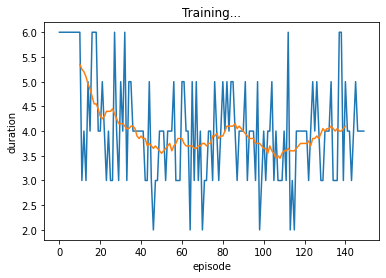

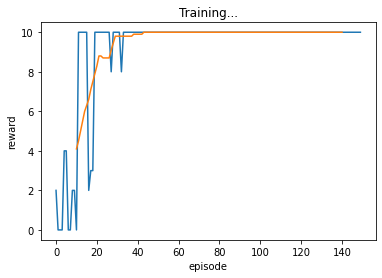

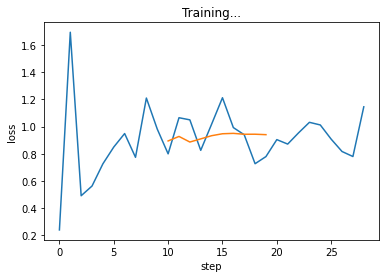

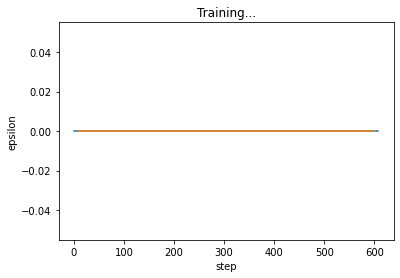

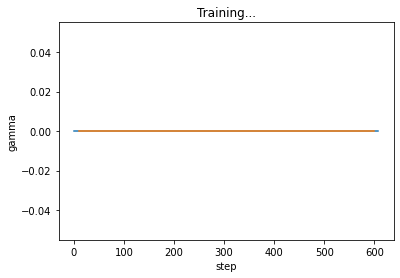

In [32]:
plot_all(*run_experiment(
    model=ModelConfig(name='linear'),
    value_function=ValueConfig(name='hybrid', gamma=[0.0, 0.0, 200]),
    eps=[0.0, 0.0, 400],
    num_episodes=150,
    training=TrainConfig(train_interval=16, batch_size=64, clear_memory=False, lr=0.07)
    ))

pn params [Parameter containing:
tensor([[-0.0020,  0.1434, -0.2200, -0.1967, -0.1029,  0.0717, -0.0053,  0.2119,
         -0.0237,  0.0707, -0.0808, -0.0525, -0.2553, -0.1770]],
       requires_grad=True), Parameter containing:
tensor([-0.1102], requires_grad=True)]
=========================episode 0 lorry======================
------guess 0 12621 jumpy [1.         1.         0.25985401 0.         0.        ]-------
reward 2.0 done False 
------guess 1 11041 gawky [1.         0.8        0.34387672 0.         0.        ]-------
reward 0 done False 
------guess 2 12621 jumpy [0.5        0.         0.25985401 0.         0.        ]-------
reward 0 done False 
------guess 3 11041 gawky [0.66666667 0.         0.34387672 0.         0.        ]-------
reward 0 done False 
------guess 4 12621 jumpy [0.5        0.         0.25985401 0.         0.        ]-------
reward 0 done False 
------guess 5 11041 gawky [0.6        0.         0.34387672 0.         0.        ]-------
reward 0 done True 
ep

reward 0 done False 
------guess 2 12621 jumpy [0.5        0.         0.25985401 0.         0.        ]-------
reward 0 done False 
------guess 3 11041 gawky [0.66666667 0.         0.34387672 0.         0.        ]-------
reward 0 done False 
------guess 4 12621 jumpy [0.5        0.         0.25985401 0.         0.        ]-------
reward 0 done False 
------guess 5 11041 gawky [0.6        0.         0.34387672 0.         0.        ]-------
reward 0 done True 
episode 8 finished.  reward [2.]  eps 0.0  steps 54  memory 48
original rewards [array([2.]), array([0]), array([0]), array([0]), array([0]), array([0])]
hybrid rewards [array([2.]), array([0]), array([0]), array([0]), array([0]), array([0])]
=========================episode 9 augur======================
------guess 0 12621 jumpy [1.         1.         0.25985401 0.         0.        ]-------
reward 2.0 done False 
------guess 1 11260 quick [1.         0.8        0.30072993 0.         0.        ]-------
reward 0 done False 
------

reward 1.0 done False 
------guess 1 12646 noise [1.         0.8        0.63292782 0.         0.        ]-------
reward 3.0 done False 
------guess 2 12731 geese [1.         0.2        0.75896188 0.66666667 0.        ]-------
reward 6.0 done True 
episode 19 finished.  reward [10.]  eps 0.0  steps 99  memory 96
original rewards [array([1.]), array([3.]), array([6.])]
hybrid rewards [array([1.]), array([3.]), array([6.])]
=========================episode 20 hippo======================
------guess 0 11530 later [1.         1.         0.73949716 0.         0.        ]-------
reward 0 done False 
------guess 1 10834 sonic [1.         1.         0.51030008 0.         0.        ]-------
reward 2.0 done False 
------guess 2 11220 opium [1.         0.6        0.41768045 0.         0.        ]-------
reward 1.0 done False 
------guess 3 12113 hippo [1.         0.2        0.41330089 0.33333333 0.        ]-------
reward 7.0 done True 
episode 20 finished.  reward [10.]  eps 0.0  steps 103  memory

reward 0 done False 
------guess 2 11382 nicer [1.         0.6        0.62530414 0.         0.        ]-------
reward 0 done False 
------guess 3 11751 buyer [1.         0.6        0.53609084 0.         0.        ]-------
reward 2.0 done False 
------guess 4 11806 dryer [1.         0.2        0.6243309  0.33333333 0.        ]-------
reward 4.0 done True 
episode 30 finished.  reward [10.]  eps 0.0  steps 146  memory 141
original rewards [array([4.]), array([0]), array([0]), array([2.]), array([4.])]
hybrid rewards [array([4.]), array([0]), array([0]), array([2.]), array([4.])]
=========================episode 31 abode======================
------guess 0 11530 later [1.         1.         0.73949716 0.         0.        ]-------
reward 2.0 done False 
------guess 1 11527 ocean [1.         0.6        0.65174371 0.         0.        ]-------
reward 1.0 done False 
------guess 2 10697 adobe [1.         0.4        0.59042985 0.         0.        ]-------
reward 5.0 done False 
------guess 3

reward 1.0 done False 
------guess 1 11147 scorn [1.         0.8        0.54728305 0.         0.        ]-------
reward 2.0 done False 
------guess 2 12244 curio [1.         0.4        0.53008921 0.         0.        ]-------
reward 0 done False 
------guess 3 11956 rocky [1.         0.4        0.44849959 0.         0.        ]-------
reward 7.0 done True 
episode 41 finished.  reward [10.]  eps 0.0  steps 192  memory 188
original rewards [array([1.]), array([2.]), array([0]), array([7.])]
hybrid rewards [array([1.]), array([2.]), array([0]), array([7.])]
=========================episode 42 hater======================
------guess 0 11530 later [1.         1.         0.73949716 0.         0.        ]-------
reward 8.0 done False 
------guess 1 10929 cater [1.         0.2        0.70024331 0.         0.        ]-------
reward 0 done False 
------guess 2 11364 hater [1.         0.2        0.68596918 0.         0.        ]-------
reward 2.0 done True 
episode 42 finished.  reward [10.]  ep

reward 0 done False 
------guess 2 11842 tooth [1.         0.6        0.54420114 0.66666667 0.        ]-------
reward 1.0 done False 
------guess 3 12835 known [1.         0.6        0.37453366 0.33333333 0.        ]-------
reward 0 done False 
------guess 4 12378 gumbo [1.         0.8        0.34533658 0.         0.        ]-------
reward 4.0 done False 
------guess 5 11432 poppy [0.6        0.4        0.36982968 0.66666667 0.        ]-------
reward 0 done True 
episode 53 finished.  reward [5.]  eps 0.0  steps 238  memory 232
original rewards [array([0]), array([0]), array([1.]), array([0]), array([4.]), array([0])]
hybrid rewards [array([0]), array([0]), array([1.]), array([0]), array([4.]), array([0])]
=========================episode 54 singe======================
------guess 0 11277 eerie [1.         0.6        0.85466342 0.66666667 0.        ]-------
reward 3.0 done False 
------guess 1 12315 aisle [1.         0.6        0.69278183 0.         0.        ]-------
reward 2.0 done F

reward 2.0 done False 
------guess 1 12471 nosey [1.         0.8        0.59302514 0.         0.        ]-------
reward 1.0 done False 
------guess 2 12427 kneed [1.         0.4        0.59107867 0.33333333 0.        ]-------
reward 7.0 done True 
episode 65 finished.  reward [10.]  eps 0.0  steps 283  memory 280
original rewards [array([2.]), array([1.]), array([7.])]
hybrid rewards [array([2.]), array([1.]), array([7.])]
=========================episode 66 nudge======================
------guess 0 11530 later [1.         1.         0.73949716 0.         0.        ]-------
reward 1.0 done False 
------guess 1 12646 noise [1.         0.8        0.63292782 0.         0.        ]-------
reward 3.0 done False 
------guess 2 11629 nudge [1.         0.6        0.48321168 0.         0.        ]-------
reward 6.0 done True 
episode 66 finished.  reward [10.]  eps 0.0  steps 286  memory 283
original rewards [array([1.]), array([3.]), array([6.])]
hybrid rewards [array([1.]), array([3.]), array

reward 2.0 done False 
------guess 1 12908 snore [1.         0.6        0.66991079 0.         0.        ]-------
reward 2.0 done False 
------guess 2 12750 serif [1.         0.4        0.60048662 0.         0.        ]-------
reward 6.0 done True 
episode 78 finished.  reward [10.]  eps 0.0  steps 329  memory 326
original rewards [array([2.]), array([2.]), array([6.])]
hybrid rewards [array([2.]), array([2.]), array([6.])]
loss 1.0128509998321533
=========================episode 79 guide======================
------guess 0 11530 later [1.         1.         0.73949716 0.         0.        ]-------
reward 1.0 done False 
------guess 1 12646 noise [1.         0.8        0.63292782 0.         0.        ]-------
reward 3.0 done False 
------guess 2 12421 chide [1.         0.6        0.51305758 0.         0.        ]-------
reward 2.0 done False 
------guess 3 12327 guide [1.         0.4        0.49878345 0.         0.        ]-------
reward 4.0 done True 
episode 79 finished.  reward [10.]

reward 0 done False 
------guess 1 12266 salsa [1.         0.6        0.6512571  0.66666667 0.        ]-------
reward 3.0 done False 
------guess 2 12537 scant [1.         0.6        0.55620438 0.         0.        ]-------
reward 2.0 done False 
------guess 3 12103 shack [1.         0.4        0.44184915 0.         0.        ]-------
reward 5.0 done True 
episode 89 finished.  reward [10.]  eps 0.0  steps 379  memory 375
original rewards [array([0]), array([3.]), array([2.]), array([5.])]
hybrid rewards [array([0]), array([3.]), array([2.]), array([5.])]
=========================episode 90 offal======================
------guess 0 11277 eerie [1.         0.6        0.85466342 0.66666667 0.        ]-------
reward 0 done False 
------guess 1 12266 salsa [1.         0.6        0.6512571  0.66666667 0.        ]-------
reward 2.0 done False 
------guess 2 11230 total [1.         0.4        0.63422547 0.33333333 0.        ]-------
reward 3.0 done False 
------guess 3 10726 offal [1.        

reward 0 done False 
------guess 4 11228 count [1.         0.4        0.48694242 0.         0.        ]-------
reward 3.0 done False 
------guess 5 11670 donut [1.         0.2        0.47331711 0.         0.        ]-------
reward 4.0 done True 
episode 99 finished.  reward [10.]  eps 0.0  steps 426  memory 420
original rewards [array([0]), array([0]), array([3.]), array([0]), array([3.]), array([4.])]
hybrid rewards [array([0]), array([0]), array([3.]), array([0]), array([3.]), array([4.])]
=========================episode 100 bulge======================
------guess 0 11277 eerie [1.         0.6        0.85466342 0.66666667 0.        ]-------
reward 2.0 done False 
------guess 1 12824 latte [1.         0.6        0.71192214 0.33333333 0.        ]-------
reward 1.0 done False 
------guess 2 12737 close [1.         0.6        0.62481752 0.         0.        ]-------
reward 0 done False 
------guess 3 12117 bugle [1.         0.6        0.48840227 0.         0.        ]-------
reward 5.0 

reward 1.0 done False 
------guess 3 11901 afoul [1.        0.4       0.5107867 0.        0.       ]-------
reward 6.0 done True 
episode 110 finished.  reward [10.]  eps 0.0  steps 471  memory 467
original rewards [array([1.]), array([2.]), array([1.]), array([6.])]
hybrid rewards [array([1.]), array([2.]), array([1.]), array([6.])]
=========================episode 111 quote======================
------guess 0 11394 eater [1.         0.8        0.82287105 0.33333333 0.        ]-------
reward 2.0 done False 
------guess 1 11875 stole [1.         0.6        0.66569343 0.         0.        ]-------
reward 3.0 done False 
------guess 2 12640 quote [1.         0.4        0.52100568 0.         0.        ]-------
reward 5.0 done True 
episode 111 finished.  reward [10.]  eps 0.0  steps 474  memory 471
original rewards [array([2.]), array([3.]), array([5.])]
hybrid rewards [array([2.]), array([3.]), array([5.])]
loss 1.0133720636367798
=========================episode 112 krill===============

reward 2.0 done False 
------guess 1 11427 snail [1.         0.6        0.58605028 0.         0.        ]-------
reward 2.0 done False 
------guess 2 12846 clang [1.         0.4        0.49651257 0.         0.        ]-------
reward 2.0 done False 
------guess 3 11060 bland [1.         0.4        0.47802109 0.         0.        ]-------
reward 4.0 done True 
episode 123 finished.  reward [10.]  eps 0.0  steps 517  memory 513
original rewards [array([2.]), array([2.]), array([2.]), array([4.])]
hybrid rewards [array([2.]), array([2.]), array([2.]), array([4.])]
=========================episode 124 erupt======================
------guess 0 11530 later [1.         1.         0.73949716 0.         0.        ]-------
reward 3.0 done False 
------guess 1 10819 store [1.         0.4        0.69489051 0.         0.        ]-------
reward 0 done False 
------guess 2 11103 merit [1.         0.4        0.62416869 0.         0.        ]-------
reward 1.0 done False 
------guess 3 11008 crept [1.  

reward 2.0 done False 
------guess 2 12771 nasal [1.         0.         0.63600973 0.33333333 0.        ]-------
reward 5.0 done True 
episode 134 finished.  reward [10.]  eps 0.0  steps 561  memory 558
original rewards [array([3.]), array([2.]), array([5.])]
hybrid rewards [array([3.]), array([2.]), array([5.])]
=========================episode 135 stick======================
------guess 0 11530 later [1.         1.         0.73949716 0.         0.        ]-------
reward 1.0 done False 
------guess 1 12063 stoic [1.         0.8        0.53527981 0.         0.        ]-------
reward 5.0 done False 
------guess 2 11480 thump [0.5        0.8        0.36788321 0.         0.        ]-------
reward 0 done False 
------guess 3 11133 stick [1.         0.2        0.44703974 0.         0.        ]-------
reward 4.0 done True 
episode 135 finished.  reward [10.]  eps 0.0  steps 565  memory 561
original rewards [array([1.]), array([5.]), array([0]), array([4.])]
hybrid rewards [array([1.]), array

reward 0 done False 
------guess 4 11434 fiber [1.         0.4        0.53755069 0.         0.        ]-------
reward 4.0 done True 
episode 145 finished.  reward [10.]  eps 0.0  steps 608  memory 603
original rewards [array([4.]), array([0]), array([2.]), array([0]), array([4.])]
hybrid rewards [array([4.]), array([0]), array([2.]), array([0]), array([4.])]
loss 1.013961672782898
=========================episode 146 urban======================
------guess 0 11530 later [1.         1.         0.73949716 0.         0.        ]-------
reward 2.0 done False 
------guess 1 11316 arson [1.         0.6        0.62871046 0.         0.        ]-------
reward 3.0 done False 
------guess 2 10720 drain [1.         0.4        0.57047851 0.         0.        ]-------
reward 0 done False 
------guess 3 11717 urban [1.         0.4        0.51922141 0.         0.        ]-------
reward 5.0 done True 
episode 146 finished.  reward [10.]  eps 0.0  steps 612  memory 608
original rewards [array([2.]), arr

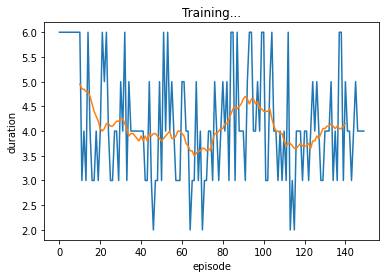

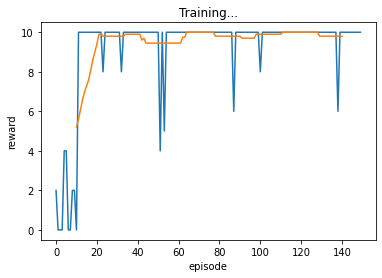

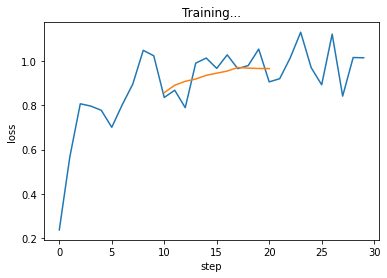

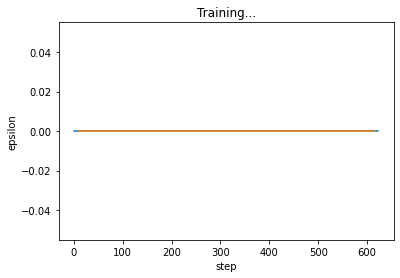

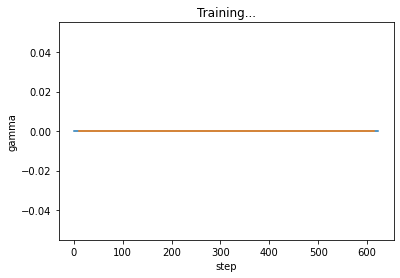

In [33]:
plot_all(*run_experiment(
    model=ModelConfig(name='linear'),
    value_function=ValueConfig(name='hybrid', gamma=[0.0, 0.0, 200]),
    eps=[0.0, 0.0, 400],
    num_episodes=150,
    training=TrainConfig(train_interval=16, batch_size=64, clear_memory=False, lr=0.03)
    ))

pn params [Parameter containing:
tensor([[-0.0020,  0.1434, -0.2200, -0.1967, -0.1029,  0.0717, -0.0053,  0.2119,
         -0.0237,  0.0707, -0.0808, -0.0525, -0.2553, -0.1770]],
       requires_grad=True), Parameter containing:
tensor([-0.1102], requires_grad=True)]
=========================episode 0 lorry======================
------guess 0 12621 jumpy [1.         1.         0.25985401 0.         0.        ]-------
reward 2.0 done False 
------guess 1 11041 gawky [1.         0.8        0.34387672 0.         0.        ]-------
reward 0 done False 
------guess 2 12621 jumpy [0.5        0.         0.25985401 0.         0.        ]-------
reward 0 done False 
------guess 3 11041 gawky [0.66666667 0.         0.34387672 0.         0.        ]-------
reward 0 done False 
------guess 4 12621 jumpy [0.5        0.         0.25985401 0.         0.        ]-------
reward 0 done False 
------guess 5 11041 gawky [0.6        0.         0.34387672 0.         0.        ]-------
reward 0 done True 
ep

reward 0 done False 
------guess 2 12621 jumpy [0.5        0.         0.25985401 0.         0.        ]-------
reward 0 done False 
------guess 3 11041 gawky [0.66666667 0.         0.34387672 0.         0.        ]-------
reward 0 done False 
------guess 4 12621 jumpy [0.5        0.         0.25985401 0.         0.        ]-------
reward 0 done False 
------guess 5 11041 gawky [0.6        0.         0.34387672 0.         0.        ]-------
reward 0 done True 
episode 8 finished.  reward [2.]  eps 0.0  steps 54  memory 48
original rewards [array([2.]), array([0]), array([0]), array([0]), array([0]), array([0])]
hybrid rewards [array([2.]), array([0]), array([0]), array([0]), array([0]), array([0])]
=========================episode 9 augur======================
------guess 0 12621 jumpy [1.         1.         0.25985401 0.         0.        ]-------
reward 2.0 done False 
------guess 1 11260 quick [1.         0.8        0.30072993 0.         0.        ]-------
reward 0 done False 
------

reward 3.0 done False 
------guess 1 12794 mamma [0.         0.         0.47137064 1.         0.        ]-------
reward 0 done False 
------guess 2 12794 mamma [0.         0.         0.47137064 1.         0.        ]-------
reward 0 done False 
------guess 3 12794 mamma [0.         0.         0.47137064 1.         0.        ]-------
reward 0 done False 
------guess 4 12794 mamma [0.         0.         0.47137064 1.         0.        ]-------
reward 0 done False 
------guess 5 12794 mamma [0.         0.         0.47137064 1.         0.        ]-------
reward 0 done True 
episode 18 finished.  reward [3.]  eps 0.0  steps 103  memory 97
original rewards [array([3.]), array([0]), array([0]), array([0]), array([0]), array([0])]
hybrid rewards [array([3.]), array([0]), array([0]), array([0]), array([0]), array([0])]
loss 0.5110563039779663
=========================episode 19 geese======================
------guess 0 6306 oater [1.         1.         0.74517437 0.         1.        ]-------
r

reward 0 done False 
------guess 4 7036 poupe [1.         0.4        0.51711273 0.33333333 1.        ]-------
reward 2.0 done False 
------guess 5 4131 homme [0.8        0.4        0.48791565 0.33333333 1.        ]-------
reward 0 done True 
episode 27 finished.  reward [6.]  eps 0.0  steps 150  memory 144
original rewards [array([2.]), array([2.]), array([0]), array([0]), array([2.]), array([0])]
hybrid rewards [array([2.]), array([2.]), array([0]), array([0]), array([2.]), array([0])]
=========================episode 28 flier======================
------guess 0 399 areae [1.         0.6        0.86342255 0.66666667 1.        ]-------
reward 2.0 done False 
------guess 1 8123 serrs [1.         0.2        0.70867802 0.66666667 1.        ]-------
reward 0 done False 
------guess 2 7720 rotte [1.         0.4        0.70462287 0.33333333 1.        ]-------
reward 0 done False 
------guess 3 4304 iller [1.         0.4        0.68791565 0.33333333 1.        ]-------
reward 5.0 done False 
-

reward 2.0 done False 
------guess 5 3713 greek [0.8        0.2        0.63033252 0.33333333 1.        ]-------
reward 0 done True 
episode 36 finished.  reward [8.]  eps 0.0  steps 198  memory 192
original rewards [array([3.]), array([0]), array([0]), array([3.]), array([2.]), array([0])]
hybrid rewards [array([3.]), array([0]), array([0]), array([3.]), array([2.]), array([0])]
loss 0.8173728585243225
=========================episode 37 chard======================
------guess 0 12621 jumpy [1.         1.         0.25985401 0.         0.        ]-------
reward 0 done False 
------guess 1 11468 whisk [1.         1.         0.34614761 0.         0.        ]-------
reward 2.0 done False 
------guess 2 12839 thong [1.         0.8        0.44736415 0.         0.        ]-------
reward 0 done False 
------guess 3 12368 chard [1.         0.8        0.50884023 0.         0.        ]-------
reward 8.0 done True 
episode 37 finished.  reward [10.]  eps 0.0  steps 202  memory 198
original rewards

reward 1.0 done False 
------guess 1 5199 lints [1.         0.8        0.54549878 0.         1.        ]-------
reward 0 done False 
------guess 2 9600 tumpy [1.         0.8        0.37372263 0.         1.        ]-------
reward 4.0 done False 
------guess 3 11480 thump [1.         0.2        0.36788321 0.         0.        ]-------
reward 5.0 done True 
episode 47 finished.  reward [10.]  eps 0.0  steps 247  memory 243
original rewards [array([1.]), array([0]), array([4.]), array([5.])]
hybrid rewards [array([1.]), array([0]), array([4.]), array([5.])]
=========================episode 48 panic======================
------guess 0 6306 oater [1.         1.         0.74517437 0.         1.        ]-------
reward 2.0 done False 
------guess 1 6031 nails [1.         0.8        0.58605028 0.         1.        ]-------
reward 2.0 done False 
------guess 2 1394 canid [1.         0.4        0.50202758 0.         1.        ]-------
reward 3.0 done False 
------guess 3 10867 panic [1.         0.

reward 3.0 done False 
------guess 3 10883 light [1.         0.2        0.45725872 0.         0.        ]-------
reward 2.0 done True 
episode 57 finished.  reward [10.]  eps 0.0  steps 293  memory 289
original rewards [array([1.]), array([4.]), array([3.]), array([2.])]
hybrid rewards [array([1.]), array([4.]), array([3.]), array([2.])]
loss 1.144636869430542
=========================episode 58 rinse======================
------guess 0 6306 oater [1.         1.         0.74517437 0.         1.        ]-------
reward 2.0 done False 
------guess 1 5089 leirs [1.         0.6        0.67980535 0.         1.        ]-------
reward 2.0 done False 
------guess 2 911 birse [1.         0.2        0.60875912 0.         1.        ]-------
reward 3.0 done False 
------guess 3 12711 rinse [1.         0.2        0.65644769 0.         0.        ]-------
reward 3.0 done True 
episode 58 finished.  reward [10.]  eps 0.0  steps 297  memory 293
original rewards [array([2.]), array([2.]), array([3.]), ar

reward 2.0 done False 
------guess 1 426 arils [1.         0.6        0.63860503 0.         1.        ]-------
reward 2.0 done False 
------guess 2 1906 craig [1.         0.4        0.54128143 0.         1.        ]-------
reward 2.0 done False 
------guess 3 3222 fraim [1.         0.4        0.50202758 0.         1.        ]-------
reward 0 done False 
------guess 4 10720 drain [1.         0.4        0.57047851 0.         0.        ]-------
reward 4.0 done True 
episode 68 finished.  reward [10.]  eps 0.0  steps 343  memory 338
original rewards [array([2.]), array([2.]), array([2.]), array([0]), array([4.])]
hybrid rewards [array([2.]), array([2.]), array([2.]), array([0]), array([4.])]
=========================episode 69 album======================
------guess 0 6306 oater [1.         1.         0.74517437 0.         1.        ]-------
reward 1.0 done False 
------guess 1 326 anils [1.         0.8        0.58605028 0.         1.        ]-------
reward 2.0 done False 
------guess 2 25

reward 3.0 done False 
------guess 2 11245 guile [1.         0.6        0.55166261 0.         0.        ]-------
reward 4.0 done False 
------guess 3 12327 guide [1.         0.2        0.49878345 0.         0.        ]-------
reward 2.0 done True 
episode 79 finished.  reward [10.]  eps 0.0  steps 388  memory 384
original rewards [array([1.]), array([3.]), array([4.]), array([2.])]
hybrid rewards [array([1.]), array([3.]), array([4.]), array([2.])]
loss 0.6957082152366638
=========================episode 80 couch======================
------guess 0 11530 later [1.         1.         0.73949716 0.         0.        ]-------
reward 0 done False 
------guess 1 10834 sonic [1.         1.         0.51030008 0.         0.        ]-------
reward 3.0 done False 
------guess 2 11713 pouch [1.         0.6        0.39805353 0.         0.        ]-------
reward 5.0 done False 
------guess 3 11005 vouch [1.         0.2        0.36334144 0.         0.        ]-------
reward 0 done False 
------guess

reward 2.0 done False 
------guess 1 11427 snail [1.         0.6        0.58605028 0.         0.        ]-------
reward 1.0 done False 
------guess 2 11762 modal [1.         0.6        0.51273317 0.         0.        ]-------
reward 2.0 done False 
------guess 3 10726 offal [1.         0.2        0.47234388 0.33333333 0.        ]-------
reward 5.0 done True 
episode 90 finished.  reward [10.]  eps 0.0  steps 435  memory 431
original rewards [array([2.]), array([1.]), array([2.]), array([5.])]
hybrid rewards [array([2.]), array([1.]), array([2.]), array([5.])]
=========================episode 91 slosh======================
------guess 0 11530 later [1.         1.         0.73949716 0.         0.        ]-------
reward 1.0 done False 
------guess 1 11537 solid [1.         0.8        0.52003244 0.         0.        ]-------
reward 3.0 done False 
------guess 2 12541 scowl [1.         0.4        0.45644769 0.         0.        ]-------
reward 1.0 done False 
------guess 3 12530 sloop [1.  

reward 1.0 done False 
------guess 2 11245 guile [1.         0.6        0.55166261 0.         0.        ]-------
reward 2.0 done False 
------guess 3 11580 bilge [1.        0.2       0.5214923 0.        0.       ]-------
reward 5.0 done True 
episode 102 finished.  reward [10.]  eps 0.0  steps 479  memory 475
original rewards [array([2.]), array([1.]), array([2.]), array([5.])]
hybrid rewards [array([2.]), array([1.]), array([2.]), array([5.])]
=========================episode 103 musty======================
------guess 0 11530 later [1.         1.         0.73949716 0.         0.        ]-------
reward 1.0 done False 
------guess 1 12063 stoic [1.         0.8        0.53527981 0.         0.        ]-------
reward 1.0 done False 
------guess 2 12130 dusty [1.        0.6       0.4351987 0.        0.       ]-------
reward 6.0 done False 
------guess 3 11213 musty [1.         0.2        0.42270884 0.         0.        ]-------
reward 2.0 done True 
episode 103 finished.  reward [10.]  eps

reward 3.0 done False 
------guess 1 11893 flirt [1.         0.4        0.52684509 0.         0.        ]-------
reward 7.0 done True 
episode 115 finished.  reward [10.]  eps 0.0  steps 524  memory 522
original rewards [array([3.]), array([7.])]
hybrid rewards [array([3.]), array([7.])]
=========================episode 116 touch======================
------guess 0 11530 later [1.         1.         0.73949716 0.         0.        ]-------
reward 1.0 done False 
------guess 1 12063 stoic [1.         0.8        0.53527981 0.         0.        ]-------
reward 2.0 done False 
------guess 2 11228 count [1.         0.4        0.48694242 0.         0.        ]-------
reward 3.0 done False 
------guess 3 11774 touch [1.        0.2       0.4567721 0.        0.       ]-------
reward 4.0 done True 
episode 116 finished.  reward [10.]  eps 0.0  steps 528  memory 524
original rewards [array([1.]), array([2.]), array([3.]), array([4.])]
hybrid rewards [array([1.]), array([2.]), array([3.]), array([

reward 3.0 done False 
------guess 1 12315 aisle [1.         0.4        0.69278183 0.         0.        ]-------
reward 3.0 done False 
------guess 2 12349 scale [1.         0.2        0.66131387 0.         0.        ]-------
reward 2.0 done False 
------guess 3 12200 shale [1.         0.2        0.64703974 0.         0.        ]-------
reward 2.0 done True 
episode 127 finished.  reward [10.]  eps 0.0  steps 572  memory 568
original rewards [array([3.]), array([3.]), array([2.]), array([2.])]
hybrid rewards [array([3.]), array([3.]), array([2.]), array([2.])]
loss 0.9938927888870239
=========================episode 128 denim======================
------guess 0 11530 later [1.         1.         0.73949716 0.         0.        ]-------
reward 1.0 done False 
------guess 1 12646 noise [1.         0.8        0.63292782 0.         0.        ]-------
reward 2.0 done False 
------guess 2 11168 denim [1.         0.4        0.51711273 0.         0.        ]-------
reward 7.0 done True 
episod

reward 0 done False 
------guess 1 10834 sonic [1.         1.         0.51030008 0.         0.        ]-------
reward 3.0 done False 
------guess 2 11637 unzip [1.         0.6        0.34387672 0.         0.        ]-------
reward 7.0 done True 
episode 139 finished.  reward [10.]  eps 0.0  steps 619  memory 616
original rewards [array([0]), array([3.]), array([7.])]
hybrid rewards [array([0]), array([3.]), array([7.])]
=========================episode 140 cheer======================
------guess 0 11530 later [1.         1.         0.73949716 0.         0.        ]-------
reward 4.0 done False 
------guess 1 11563 poser [1.         0.6        0.63617194 0.         0.        ]-------
reward 0 done False 
------guess 2 11382 nicer [1.         0.6        0.62530414 0.         0.        ]-------
reward 1.0 done False 
------guess 3 11787 cyber [1.        0.4       0.5377129 0.        0.       ]-------
reward 1.0 done False 
------guess 4 12363 cheer [1.         0.2        0.68629359 0.3333

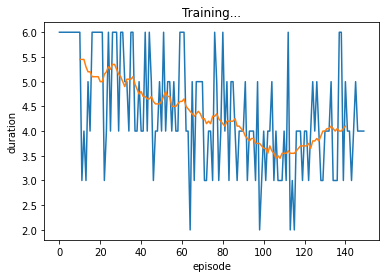

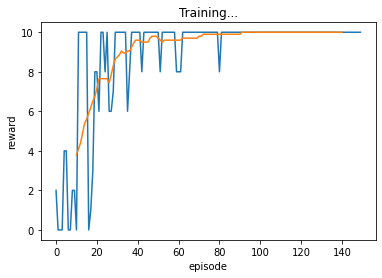

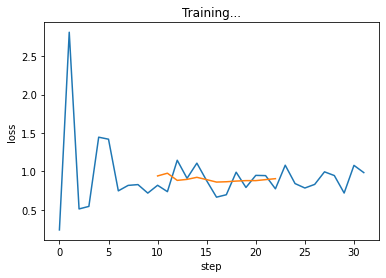

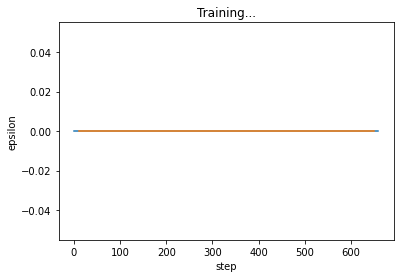

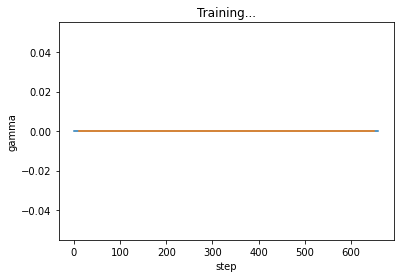

In [34]:
plot_all(*run_experiment(
    model=ModelConfig(name='linear'),
    value_function=ValueConfig(name='hybrid', gamma=[0.0, 0.0, 200]),
    eps=[0.0, 0.0, 400],
    num_episodes=150,
    training=TrainConfig(train_interval=16, batch_size=64, clear_memory=False, lr=0.1)
    ))

pn params [Parameter containing:
tensor([[-0.0020,  0.1434, -0.2200, -0.1967, -0.1029,  0.0717, -0.0053,  0.2119,
         -0.0237,  0.0707, -0.0808, -0.0525, -0.2553, -0.1770]],
       requires_grad=True), Parameter containing:
tensor([-0.1102], requires_grad=True)]
=========================episode 0 lorry======================
------guess 0 12621 jumpy [1.         1.         0.25985401 0.         0.        ]-------
reward 2.0 done False 
------guess 1 11041 gawky [1.         0.8        0.34387672 0.         0.        ]-------
reward 0 done False 
------guess 2 12621 jumpy [0.5        0.         0.25985401 0.         0.        ]-------
reward 0 done False 
------guess 3 11041 gawky [0.66666667 0.         0.34387672 0.         0.        ]-------
reward 0 done False 
------guess 4 12621 jumpy [0.5        0.         0.25985401 0.         0.        ]-------
reward 0 done False 
------guess 5 11041 gawky [0.6        0.         0.34387672 0.         0.        ]-------
reward 0 done True 
ep

reward 0 done False 
------guess 2 12621 jumpy [0.5        0.         0.25985401 0.         0.        ]-------
reward 0 done False 
------guess 3 11041 gawky [0.66666667 0.         0.34387672 0.         0.        ]-------
reward 0 done False 
------guess 4 12621 jumpy [0.5        0.         0.25985401 0.         0.        ]-------
reward 0 done False 
------guess 5 11041 gawky [0.6        0.         0.34387672 0.         0.        ]-------
reward 0 done True 
episode 8 finished.  reward [2.]  eps 0.0  steps 54  memory 48
original rewards [array([2.]), array([0]), array([0]), array([0]), array([0]), array([0])]
hybrid rewards [array([1.4]), array([0]), array([0]), array([0]), array([0]), array([0])]
=========================episode 9 augur======================
------guess 0 12621 jumpy [1.         1.         0.25985401 0.         0.        ]-------
reward 2.0 done False 
------guess 1 11260 quick [1.         0.8        0.30072993 0.         0.        ]-------
reward 0 done False 
-----

reward 3.0 done False 
------guess 1 12794 mamma [0.         0.         0.47137064 1.         0.        ]-------
reward 0 done False 
------guess 2 12794 mamma [0.         0.         0.47137064 1.         0.        ]-------
reward 0 done False 
------guess 3 12794 mamma [0.         0.         0.47137064 1.         0.        ]-------
reward 0 done False 
------guess 4 12794 mamma [0.         0.         0.47137064 1.         0.        ]-------
reward 0 done False 
------guess 5 12794 mamma [0.         0.         0.47137064 1.         0.        ]-------
reward 0 done True 
episode 18 finished.  reward [3.]  eps 0.0  steps 103  memory 97
original rewards [array([3.]), array([0]), array([0]), array([0]), array([0]), array([0])]
hybrid rewards [array([2.4]), array([0]), array([0]), array([0]), array([0]), array([0])]
loss 0.5371829867362976
=========================episode 19 geese======================
------guess 0 11530 later [1.         1.         0.73949716 0.         0.        ]-------

reward 3.0 done False 
------guess 2 10710 flesh [1.         0.4        0.52554745 0.         0.        ]-------
reward 5.0 done True 
episode 29 finished.  reward [10.]  eps 0.0  steps 145  memory 142
original rewards [array([2.]), array([3.]), array([5.])]
hybrid rewards [array([2.9]), array([3.9]), array([5.9])]
=========================episode 30 dryer======================
------guess 0 11530 later [1.         1.         0.73949716 0.         0.        ]-------
reward 4.0 done False 
------guess 1 11563 poser [1.         0.6        0.63617194 0.         0.        ]-------
reward 0 done False 
------guess 2 11382 nicer [1.         0.6        0.62530414 0.         0.        ]-------
reward 0 done False 
------guess 3 11751 buyer [1.         0.6        0.53609084 0.         0.        ]-------
reward 2.0 done False 
------guess 4 11806 dryer [1.         0.2        0.6243309  0.33333333 0.        ]-------
reward 4.0 done True 
episode 30 finished.  reward [10.]  eps 0.0  steps 150  mem

reward 3.0 done False 
------guess 1 11249 canoe [1.         0.6        0.65174371 0.         0.        ]-------
reward 1.0 done False 
------guess 2 10893 pause [1.        0.6       0.6025953 0.        0.       ]-------
reward 2.0 done False 
------guess 3 12702 mauve [1.         0.4        0.51062449 0.         0.        ]-------
reward 4.0 done True 
episode 40 finished.  reward [10.]  eps 0.0  steps 195  memory 191
original rewards [array([3.]), array([1.]), array([2.]), array([4.])]
hybrid rewards [array([3.6]), array([1.6]), array([2.6]), array([4.6])]
=========================episode 41 rocky======================
------guess 0 11530 later [1.         1.         0.73949716 0.         0.        ]-------
reward 1.0 done False 
------guess 1 11147 scorn [1.         0.8        0.54728305 0.         0.        ]-------
reward 2.0 done False 
------guess 2 12244 curio [1.         0.4        0.53008921 0.         0.        ]-------
reward 0 done False 
------guess 3 11956 rocky [1.     

reward 0 done False 
------guess 1 10834 sonic [1.         1.         0.51030008 0.         0.        ]-------
reward 1.0 done False 
------guess 2 12378 gumbo [1.         0.8        0.34533658 0.         0.        ]-------
reward 4.0 done False 
------guess 3 11664 buxom [1.         0.2        0.30089213 0.         0.        ]-------
reward 5.0 done True 
episode 53 finished.  reward [10.]  eps 0.0  steps 240  memory 236
original rewards [array([0]), array([1.]), array([4.]), array([5.])]
hybrid rewards [array([0]), array([1.6]), array([4.6]), array([5.6])]
=========================episode 54 singe======================
------guess 0 11530 later [1.         1.         0.73949716 0.         0.        ]-------
reward 1.0 done False 
------guess 1 12646 noise [1.         0.8        0.63292782 0.         0.        ]-------
reward 4.0 done False 
------guess 2 11558 since [1.         0.2        0.58799676 0.         0.        ]-------
reward 3.0 done False 
------guess 3 11285 singe [1.   

reward 2.0 done False 
------guess 1 12471 nosey [1.         0.8        0.59302514 0.         0.        ]-------
reward 1.0 done False 
------guess 2 12282 widen [1.         0.6        0.49748581 0.         0.        ]-------
reward 1.0 done False 
------guess 3 10693 unfed [1.         0.4        0.47007299 0.         0.        ]-------
reward 2.0 done False 
------guess 4 12427 kneed [1.         0.2        0.59107867 0.33333333 0.        ]-------
reward 4.0 done True 
episode 65 finished.  reward [10.]  eps 0.0  steps 287  memory 282
original rewards [array([2.]), array([1.]), array([1.]), array([2.]), array([4.])]
hybrid rewards [array([2.3]), array([1.3]), array([1.3]), array([2.3]), array([4.3])]
=========================episode 66 nudge======================
------guess 0 11530 later [1.         1.         0.73949716 0.         0.        ]-------
reward 1.0 done False 
------guess 1 12646 noise [1.         0.8        0.63292782 0.         0.        ]-------
reward 3.0 done False 


reward 3.0 done False 
------guess 2 11945 cause [1.         0.4        0.62043796 0.         0.        ]-------
reward 0 done False 
------guess 3 11994 cache [1.         0.2        0.57664234 0.33333333 0.        ]-------
reward 4.0 done True 
episode 77 finished.  reward [10.]  eps 0.0  steps 330  memory 326
original rewards [array([3.]), array([3.]), array([0]), array([4.])]
hybrid rewards [array([3.6]), array([3.6]), array([0]), array([4.6])]
=========================episode 78 serif======================
------guess 0 11530 later [1.         1.         0.73949716 0.         0.        ]-------
reward 2.0 done False 
------guess 1 12908 snore [1.         0.6        0.66991079 0.         0.        ]-------
reward 2.0 done False 
------guess 2 12750 serif [1.         0.4        0.60048662 0.         0.        ]-------
reward 6.0 done True 
episode 78 finished.  reward [10.]  eps 0.0  steps 333  memory 330
original rewards [array([2.]), array([2.]), array([6.])]
hybrid rewards [array(

reward 3.0 done False 
------guess 3 11556 eight [1.        0.4       0.5406326 0.        0.       ]-------
reward 5.0 done True 
episode 88 finished.  reward [10.]  eps 0.0  steps 375  memory 371
original rewards [array([2.]), array([0]), array([3.]), array([5.])]
hybrid rewards [array([2.6]), array([0]), array([3.6]), array([5.6])]
=========================episode 89 shack======================
------guess 0 11530 later [1.         1.         0.73949716 0.         0.        ]-------
reward 1.0 done False 
------guess 1 11822 piano [1.         0.8        0.54274128 0.         0.        ]-------
reward 1.0 done False 
------guess 2 11683 shady [1.         0.8        0.46309813 0.         0.        ]-------
reward 4.0 done False 
------guess 3 12103 shack [1.         0.4        0.44184915 0.         0.        ]-------
reward 4.0 done True 
episode 89 finished.  reward [10.]  eps 0.0  steps 379  memory 375
original rewards [array([1.]), array([1.]), array([4.]), array([4.])]
hybrid rewar

reward 3.0 done False 
------guess 3 12472 bulge [1.         0.2        0.48840227 0.         0.        ]-------
reward 4.0 done True 
episode 100 finished.  reward [10.]  eps 0.0  steps 420  memory 416
original rewards [array([2.]), array([1.]), array([3.]), array([4.])]
hybrid rewards [array([2.6]), array([1.6]), array([3.6]), array([4.6])]
loss 1.005935549736023
=========================episode 101 harem======================
------guess 0 11530 later [1.         1.         0.73949716 0.         0.        ]-------
reward 5.0 done False 
------guess 1 11828 ramen [1.         0.4        0.64914842 0.         0.        ]-------
reward 1.0 done False 
------guess 2 11630 harem [1.        0.2       0.6189781 0.        0.       ]-------
reward 4.0 done True 
episode 101 finished.  reward [10.]  eps 0.0  steps 423  memory 420
original rewards [array([5.]), array([1.]), array([4.])]
hybrid rewards [array([5.9]), array([1.9]), array([4.9])]
=========================episode 102 bilge=========

reward 0 done False 
------guess 5 12486 krill [1.         0.2        0.52197891 0.33333333 0.        ]-------
reward 2.0 done True 
episode 112 finished.  reward [10.]  eps 0.0  steps 465  memory 459
original rewards [array([2.]), array([3.]), array([3.]), array([0]), array([0]), array([2.])]
hybrid rewards [array([2.]), array([3.]), array([3.]), array([0]), array([0]), array([2.])]
=========================episode 113 ocean======================
------guess 0 11530 later [1.         1.         0.73949716 0.         0.        ]-------
reward 2.0 done False 
------guess 1 11527 ocean [1.         0.6        0.65174371 0.         0.        ]-------
reward 8.0 done True 
episode 113 finished.  reward [10.]  eps 0.0  steps 467  memory 465
original rewards [array([2.]), array([8.])]
hybrid rewards [array([3.2]), array([9.2])]
=========================episode 114 color======================
------guess 0 11530 later [1.         1.         0.73949716 0.         0.        ]-------
reward 3.0 d

reward 1.0 done False 
------guess 1 11147 scorn [1.         0.8        0.54728305 0.         0.        ]-------
reward 2.0 done False 
------guess 2 12373 proud [1.         0.6        0.46715328 0.         0.        ]-------
reward 4.0 done False 
------guess 3 10801 group [1.         0.2        0.45385239 0.         0.        ]-------
reward 3.0 done True 
episode 125 finished.  reward [10.]  eps 0.0  steps 511  memory 507
original rewards [array([1.]), array([2.]), array([4.]), array([3.])]
hybrid rewards [array([1.6]), array([2.6]), array([4.6]), array([3.6])]
=========================episode 126 float======================
------guess 0 11530 later [1.         1.         0.73949716 0.         0.        ]-------
reward 3.0 done False 
------guess 1 12917 tonal [1.         0.4        0.60924574 0.         0.        ]-------
reward 2.0 done False 
------guess 2 11033 gloat [1.         0.2        0.56642336 0.         0.        ]-------
reward 3.0 done False 
------guess 3 11880 bloat

reward 2.0 done False 
------guess 1 12908 snore [1.         0.6        0.66991079 0.         0.        ]-------
reward 1.0 done False 
------guess 2 11286 price [1.         0.6        0.59156529 0.         0.        ]-------
reward 5.0 done False 
------guess 3 10687 pride [1.         0.2        0.57793998 0.         0.        ]-------
reward 0 done False 
------guess 4 11611 prime [1.         0.2        0.56545012 0.         0.        ]-------
reward 0 done False 
------guess 5 11114 prize [1.         0.2        0.52068127 0.         0.        ]-------
reward 2.0 done True 
episode 137 finished.  reward [10.]  eps 0.0  steps 558  memory 552
original rewards [array([2.]), array([1.]), array([5.]), array([0]), array([0]), array([2.])]
hybrid rewards [array([2.]), array([1.]), array([5.]), array([0]), array([0]), array([2.])]
=========================episode 138 staff======================
------guess 0 11530 later [1.         1.         0.73949716 0.         0.        ]-------
reward 2

reward 2.0 done False 
------guess 1 11449 mason [1.         0.8        0.53414436 0.         0.        ]-------
reward 1.0 done False 
------guess 2 10867 panic [1.         0.6        0.49781022 0.         0.        ]-------
reward 1.0 done False 
------guess 3 11298 handy [1.         0.6        0.44785077 0.         0.        ]-------
reward 6.0 done True 
episode 148 finished.  reward [10.]  eps 0.0  steps 604  memory 600
original rewards [array([2.]), array([1.]), array([1.]), array([6.])]
hybrid rewards [array([2.6]), array([1.6]), array([1.6]), array([6.6])]
=========================episode 149 truss======================
------guess 0 11530 later [1.         1.         0.73949716 0.         0.        ]-------
reward 2.0 done False 
------guess 1 12049 snort [1.         0.6        0.58815896 0.         0.        ]-------
reward 1.0 done False 
------guess 2 11038 rusty [1.         0.4        0.51727494 0.         0.        ]-------
reward 1.0 done False 
------guess 3 10855 truss

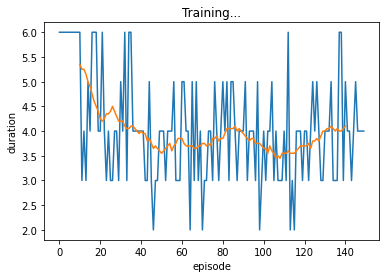

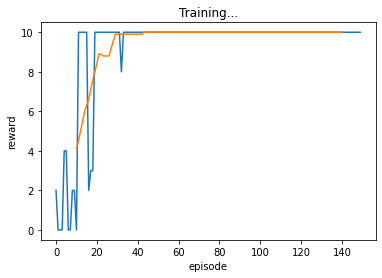

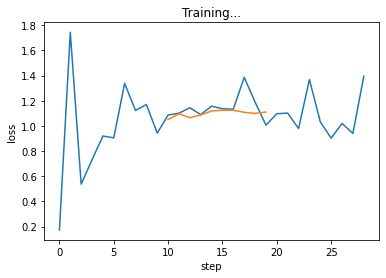

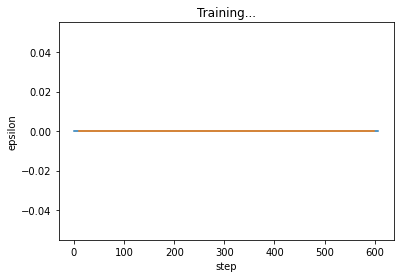

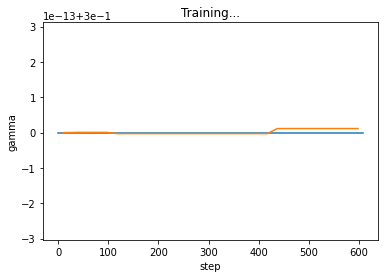

In [35]:
plot_all(*run_experiment(
    model=ModelConfig(name='linear'),
    value_function=ValueConfig(name='hybrid', gamma=[0.3, 0.3, 200]),
    eps=[0.0, 0.0, 400],
    num_episodes=150,
    training=TrainConfig(train_interval=16, batch_size=64, clear_memory=False, lr=0.07)
    ))

pn params [Parameter containing:
tensor([[-0.0020,  0.1434, -0.2200, -0.1967, -0.1029,  0.0717, -0.0053,  0.2119,
         -0.0237,  0.0707, -0.0808, -0.0525, -0.2553, -0.1770]],
       requires_grad=True), Parameter containing:
tensor([-0.1102], requires_grad=True)]
=========================episode 0 lorry======================
------guess 0 12621 jumpy [1.         1.         0.25985401 0.         0.        ]-------
reward 2.0 done False 
------guess 1 11041 gawky [1.         0.8        0.34387672 0.         0.        ]-------
reward 0 done False 
------guess 2 12621 jumpy [0.5        0.         0.25985401 0.         0.        ]-------
reward 0 done False 
------guess 3 11041 gawky [0.66666667 0.         0.34387672 0.         0.        ]-------
reward 0 done False 
------guess 4 12621 jumpy [0.5        0.         0.25985401 0.         0.        ]-------
reward 0 done False 
------guess 5 11041 gawky [0.6        0.         0.34387672 0.         0.        ]-------
reward 0 done True 
ep

reward 2.0 done False 
------guess 1 11041 gawky [1.         0.8        0.34387672 0.         0.        ]-------
reward 0 done False 
------guess 2 12621 jumpy [0.5        0.         0.25985401 0.         0.        ]-------
reward 0 done False 
------guess 3 11041 gawky [0.66666667 0.         0.34387672 0.         0.        ]-------
reward 0 done False 
------guess 4 12621 jumpy [0.5        0.         0.25985401 0.         0.        ]-------
reward 0 done False 
------guess 5 11041 gawky [0.6        0.         0.34387672 0.         0.        ]-------
reward 0 done True 
episode 8 finished.  reward [2.]  eps 0.0  gamma 0.6  steps 54  memory 48
original rewards [array([2.]), array([0]), array([0]), array([0]), array([0]), array([0])]
hybrid rewards [array([0.8]), array([0]), array([0]), array([0]), array([0]), array([0])]
=========================episode 9 augur======================
------guess 0 12621 jumpy [1.         1.         0.25985401 0.         0.        ]-------
reward 2.0 done

reward 3.0 done False 
------guess 1 12794 mamma [0.         0.         0.47137064 1.         0.        ]-------
reward 0 done False 
------guess 2 12794 mamma [0.         0.         0.47137064 1.         0.        ]-------
reward 0 done False 
------guess 3 12794 mamma [0.         0.         0.47137064 1.         0.        ]-------
reward 0 done False 
------guess 4 12794 mamma [0.         0.         0.47137064 1.         0.        ]-------
reward 0 done False 
------guess 5 12794 mamma [0.         0.         0.47137064 1.         0.        ]-------
reward 0 done True 
episode 18 finished.  reward [3.]  eps 0.0  gamma 0.6  steps 103  memory 97
original rewards [array([3.]), array([0]), array([0]), array([0]), array([0]), array([0])]
hybrid rewards [array([1.8]), array([0]), array([0]), array([0]), array([0]), array([0])]
loss 0.6340651512145996
=========================episode 19 geese======================
------guess 0 11530 later [1.         1.         0.73949716 0.         0.     

reward 2.0 done False 
------guess 1 12737 close [1.         0.6        0.62481752 0.         0.        ]-------
reward 3.0 done False 
------guess 2 10710 flesh [1.         0.4        0.52554745 0.         0.        ]-------
reward 5.0 done True 
episode 29 finished.  reward [10.]  eps 0.0  gamma 0.6  steps 147  memory 144
original rewards [array([2.]), array([3.]), array([5.])]
hybrid rewards [array([3.8]), array([4.8]), array([6.8])]
=========================episode 30 dryer======================
------guess 0 11530 later [1.         1.         0.73949716 0.         0.        ]-------
reward 4.0 done False 
------guess 1 11563 poser [1.         0.6        0.63617194 0.         0.        ]-------
reward 0 done False 
------guess 2 11382 nicer [1.         0.6        0.62530414 0.         0.        ]-------
reward 0 done False 
------guess 3 11751 buyer [1.         0.6        0.53609084 0.         0.        ]-------
reward 2.0 done False 
------guess 4 11806 dryer [1.         0.2      

reward 0 done False 
------guess 1 5415 lysin [1.         1.         0.49618816 0.         1.        ]-------
reward 1.0 done False 
------guess 2 1607 chums [1.         0.8        0.37599351 0.         1.        ]-------
reward 4.0 done False 
------guess 3 4229 humps [1.         0.2        0.35815085 0.         1.        ]-------
reward 3.0 done False 
------guess 4 4227 humfs [1.         0.2        0.33592863 0.         1.        ]-------
reward 0 done False 
------guess 5 4226 humas [0.8        0.         0.45742092 0.         1.        ]-------
reward 0 done True 
episode 39 finished.  reward [8.]  eps 0.0  gamma 0.6  steps 200  memory 194
original rewards [array([0]), array([1.]), array([4.]), array([3.]), array([0]), array([0])]
hybrid rewards [array([0]), array([0.]), array([2.8]), array([1.8]), array([0]), array([0])]
loss 1.197332501411438
=========================episode 40 mauve======================
------guess 0 11530 later [1.         1.         0.73949716 0.         0. 

reward 2.0 done False 
------guess 1 11449 mason [1.         0.8        0.53414436 0.         0.        ]-------
reward 0 done False 
------guess 2 10806 gaudy [1.         0.8        0.41768045 0.         0.        ]-------
reward 3.0 done False 
------guess 3 11779 vapid [0.66666667 0.6        0.41573398 0.         0.        ]-------
reward 0 done False 
------guess 4 11065 wacky [0.75       0.6        0.37080292 0.         0.        ]-------
reward 0 done False 
------guess 5 11915 baggy [1.         0.2        0.37420925 0.33333333 0.        ]-------
reward 5.0 done True 
episode 51 finished.  reward [10.]  eps 0.0  gamma 0.6  steps 244  memory 238
original rewards [array([2.]), array([0]), array([3.]), array([0]), array([0]), array([5.])]
hybrid rewards [array([2.]), array([0]), array([3.]), array([0]), array([0]), array([5.])]
=========================episode 52 ivory======================
------guess 0 11530 later [1.         1.         0.73949716 0.         0.        ]-------
rew

reward 0 done False 
------guess 1 10834 sonic [1.         1.         0.51030008 0.         0.        ]-------
reward 2.0 done False 
------guess 2 11093 hunky [1.        0.8       0.3351176 0.        0.       ]-------
reward 6.0 done False 
------guess 3 12475 funky [1.         0.2        0.30932685 0.         0.        ]-------
reward 2.0 done True 
episode 62 finished.  reward [10.]  eps 0.0  gamma 0.6  steps 287  memory 283
original rewards [array([0]), array([2.]), array([6.]), array([2.])]
hybrid rewards [array([1]), array([3.2]), array([7.2]), array([3.2])]
=========================episode 63 humus======================
------guess 0 11530 later [1.         1.         0.73949716 0.         0.        ]-------
reward 0 done False 
------guess 1 10834 sonic [1.         1.         0.51030008 0.         0.        ]-------
reward 1.0 done False 
------guess 2 11362 pushy [1.         0.8        0.37583131 0.         0.        ]-------
reward 3.0 done False 
------guess 3 12214 humus [1

reward 0 done False 
------guess 3 12860 fauna [1.         0.4        0.52392539 0.33333333 0.        ]-------
reward 7.0 done True 
episode 74 finished.  reward [10.]  eps 0.0  gamma 0.6  steps 329  memory 325
original rewards [array([2.]), array([1.]), array([0]), array([7.])]
hybrid rewards [array([3.2]), array([2.2]), array([1]), array([8.2])]
loss 1.4306024312973022
=========================episode 75 dairy======================
------guess 0 11530 later [1.         1.         0.73949716 0.         0.        ]-------
reward 3.0 done False 
------guess 1 10812 radio [1.         0.6        0.59951338 0.         0.        ]-------
reward 2.0 done False 
------guess 2 11687 dairy [1.         0.2        0.54614761 0.         0.        ]-------
reward 5.0 done True 
episode 75 finished.  reward [10.]  eps 0.0  gamma 0.6  steps 332  memory 329
original rewards [array([3.]), array([2.]), array([5.])]
hybrid rewards [array([4.8]), array([3.8]), array([6.8])]
=========================episod

reward 0 done False 
------guess 3 11820 datum [1.         0.6        0.46780211 0.         0.        ]-------
reward 0 done False 
------guess 4 10686 batty [1.         0.4        0.50981346 0.33333333 0.        ]-------
reward 6.0 done True 
episode 85 finished.  reward [10.]  eps 0.0  gamma 0.6  steps 375  memory 370
original rewards [array([4.]), array([0]), array([0]), array([0]), array([6.])]
hybrid rewards [array([4.6]), array([0]), array([0]), array([0]), array([6.6])]
=========================episode 86 boost======================
------guess 0 11530 later [1.         1.         0.73949716 0.         0.        ]-------
reward 1.0 done False 
------guess 1 12063 stoic [1.         0.8        0.53527981 0.         0.        ]-------
reward 3.0 done False 
------guess 2 11374 ghost [1.         0.4        0.46261152 0.         0.        ]-------
reward 2.0 done False 
------guess 3 10854 boost [1.         0.2        0.51695053 0.33333333 0.        ]-------
reward 4.0 done True 
epi

reward 2.0 done False 
------guess 1 11427 snail [1.         0.6        0.58605028 0.         0.        ]-------
reward 0 done False 
------guess 2 11182 aloud [1.         0.6        0.53722628 0.         0.        ]-------
reward 1.0 done False 
------guess 3 11452 amply [1.         0.6        0.45515004 0.         0.        ]-------
reward 5.0 done False 
------guess 4 11850 apply [1.         0.         0.46342255 0.33333333 0.        ]-------
reward 2.0 done True 
episode 97 finished.  reward [10.]  eps 0.0  gamma 0.6  steps 422  memory 417
original rewards [array([2.]), array([0]), array([1.]), array([5.]), array([2.])]
hybrid rewards [array([2.6]), array([0]), array([1.6]), array([5.6]), array([2.6])]
=========================episode 98 after======================
------guess 0 11530 later [1.         1.         0.73949716 0.         0.        ]-------
reward 7.0 done False 
------guess 1 12031 after [1.         0.2        0.66017843 0.         0.        ]-------
reward 3.0 done T

reward 0 done False 
------guess 2 11462 edict [1.         0.6        0.56820762 0.         0.        ]-------
reward 8.0 done True 
episode 109 finished.  reward [10.]  eps 0.0  gamma 0.6  steps 463  memory 460
original rewards [array([2.]), array([0]), array([8.])]
hybrid rewards [array([3.8]), array([1]), array([9.8])]
=========================episode 110 afoul======================
------guess 0 11530 later [1.         1.         0.73949716 0.         0.        ]-------
reward 2.0 done False 
------guess 1 11427 snail [1.         0.6        0.58605028 0.         0.        ]-------
reward 1.0 done False 
------guess 2 11762 modal [1.         0.6        0.51273317 0.         0.        ]-------
reward 1.0 done False 
------guess 3 11901 afoul [1.        0.4       0.5107867 0.        0.       ]-------
reward 6.0 done True 
episode 110 finished.  reward [10.]  eps 0.0  gamma 0.6  steps 467  memory 463
original rewards [array([2.]), array([1.]), array([1.]), array([6.])]
hybrid rewards [

reward 2.0 done False 
------guess 1 12908 snore [1.         0.6        0.66991079 0.         0.        ]-------
reward 2.0 done False 
------guess 2 12091 urine [1.         0.4        0.62368208 0.         0.        ]-------
reward 6.0 done True 
episode 122 finished.  reward [10.]  eps 0.0  gamma 0.6  steps 509  memory 506
original rewards [array([2.]), array([2.]), array([6.])]
hybrid rewards [array([3.8]), array([3.8]), array([7.8])]
=========================episode 123 bland======================
------guess 0 11530 later [1.         1.         0.73949716 0.         0.        ]-------
reward 2.0 done False 
------guess 1 11427 snail [1.         0.6        0.58605028 0.         0.        ]-------
reward 2.0 done False 
------guess 2 12846 clang [1.         0.4        0.49651257 0.         0.        ]-------
reward 2.0 done False 
------guess 3 11060 bland [1.         0.4        0.47802109 0.         0.        ]-------
reward 4.0 done True 
episode 123 finished.  reward [10.]  eps 0

reward 1.0 done False 
------guess 3 12404 began [1.         0.4        0.54809408 0.         0.        ]-------
reward 2.0 done False 
------guess 4 12801 vegan [1.         0.2        0.52733171 0.         0.        ]-------
reward 2.0 done True 
episode 133 finished.  reward [10.]  eps 0.0  gamma 0.6  steps 554  memory 549
original rewards [array([2.]), array([3.]), array([1.]), array([2.]), array([2.])]
hybrid rewards [array([2.6]), array([3.6]), array([1.6]), array([2.6]), array([2.6])]
=========================episode 134 nasal======================
------guess 0 11530 later [1.         1.         0.73949716 0.         0.        ]-------
reward 3.0 done False 
------guess 1 11628 salon [1.         0.6        0.59951338 0.         0.        ]-------
reward 2.0 done False 
------guess 2 12771 nasal [1.         0.         0.63600973 0.33333333 0.        ]-------
reward 5.0 done True 
episode 134 finished.  reward [10.]  eps 0.0  gamma 0.6  steps 557  memory 554
original rewards [arra

reward 2.0 done False 
------guess 3 11115 fungi [1.         0.4        0.36561233 0.         0.        ]-------
reward 5.0 done True 
episode 144 finished.  reward [10.]  eps 0.0  gamma 0.6  steps 598  memory 594
original rewards [array([0]), array([3.]), array([2.]), array([5.])]
hybrid rewards [array([1]), array([4.2]), array([3.2]), array([6.2])]
=========================episode 145 fiber======================
------guess 0 11530 later [1.         1.         0.73949716 0.         0.        ]-------
reward 4.0 done False 
------guess 1 11563 poser [1.         0.6        0.63617194 0.         0.        ]-------
reward 0 done False 
------guess 2 11382 nicer [1.         0.6        0.62530414 0.         0.        ]-------
reward 2.0 done False 
------guess 3 11990 wider [1.         0.4        0.55004055 0.         0.        ]-------
reward 0 done False 
------guess 4 11434 fiber [1.         0.4        0.53755069 0.         0.        ]-------
reward 4.0 done True 
episode 145 finished. 

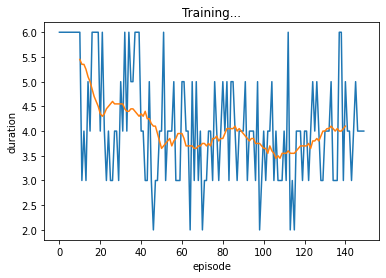

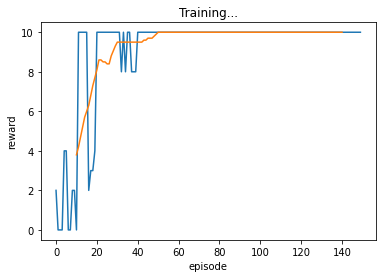

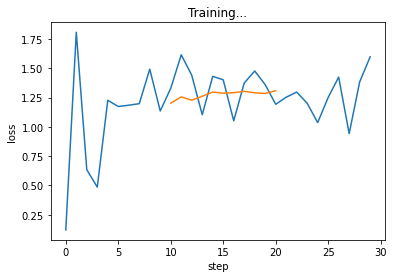

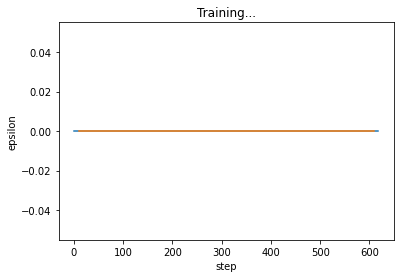

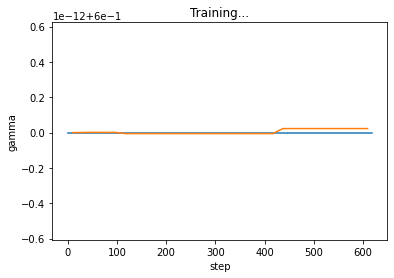

In [44]:
plot_all(*run_experiment(
    model=ModelConfig(name='linear'),
    value_function=ValueConfig(name='hybrid', gamma=[0.6, 0.6, 200]),
    eps=[0.0, 0.0, 400],
    num_episodes=150,
    training=TrainConfig(train_interval=16, batch_size=64, clear_memory=False, lr=0.07)
    ))